# Non-parametric SFH binning can be very different between binning the true SFH directly and inferring bins from the spectrum
Currenly only the Iyer binning scheme is implemented in Bagpipes, so only side to side comparison for that scheme (from 2 to 15 bin) can be provided.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/hin/Documents/St_Andrews/dense_basis')
import dense_basis as db

from george import kernels
import george
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

from scipy.optimize import minimize
import pickle

import bagpipes as pipes
from PyAstronomy import pyasl

import os
os.chdir('..')

### First define the functions related to GP fitting

In [293]:
def nll(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_nll(p, gp, y):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

def gp_interpolator(x,y,res = 1000, Nparam = 3, decouple_sfr = False, var=False, sample=None):

    yerr = np.zeros_like(y)
    yerr[2:(2+Nparam)] = 0.001/np.sqrt(Nparam)
    if len(yerr) > 26:
        yerr[2:(2+Nparam)] = 0.1/np.sqrt(Nparam)
    yerr[(2+Nparam):] = 0.1
    #kernel = np.var(y) * kernels.ExpSquaredKernel(np.median(y))
    #kernel = np.var(y) * kernels.LinearKernel(np.median(y),order=1)
    #kernel = np.var(y) * kernels.Matern32Kernel(np.median(y)) #+ k2
    kernel = np.var(y) * (kernels.Matern32Kernel(np.median(y)) + kernels.LinearKernel(np.median(y), order=2))
    gp = george.GP(kernel, solver=george.HODLRSolver)

    #print(xax.shape, yerr.shape)
    #gp.compute(x.ravel(), yerr.ravel())
    # the choices of yerr in dense_basis seems arbituary, switching them off for now
    gp.compute(x.ravel())
    
    # optimize kernel parameters
    #p0 = gp.get_parameter_vector()
    #results = minimize(nll, p0, jac=grad_nll, method="L-BFGS-B", args = (gp, y))
    #print(results)
    #gp.set_parameter_vector(results.x)

    x_pred = np.linspace(np.amin(x), np.amax(x), res)
    y_pred, pred_var = gp.predict(y.ravel(), x_pred, return_var=True)
    
    if var==True:
        if sample is not None:
            samples = gp.sample_conditional(y.ravel(), x_pred, size=sample)
            return x_pred, y_pred, pred_var, samples
        else:
            return x_pred, y_pred, pred_var
    else:
        return x_pred, y_pred

def treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
              decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=None):
    sfh = (np.diff(mass_arr_interp)*10**(sfh_tuple[0])) / (np.diff(time_arr_interp)*cosmo.age(zval).value*1e9)
    #sfh_scale = 10**(sfh_tuple[0])/(cosmo.age(zval).value*1e9/1000)
    #sfh = np.diff(mass_arr_interp)*sfh_scale
    sfh[sfh<0] = 0
    sfh = np.insert(sfh,0,[0])
    if pred_var is not None:
        sfh_var = (pred_var[1:]+pred_var[:-1]) * (10**(sfh_tuple[0])/(np.diff(time_arr_interp)*cosmo.age(zval).value*1e9))**2
        sfh_var = np.insert(sfh_var,0,[0])
    
    sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
    if sfr_decouple_time_index == 0:
        sfr_decouple_time_index = 2
    mass_lastbins = np.trapz(x=time_arr_interp[-sfr_decouple_time_index:]*1e9*(cosmo.age(zval).value), y=sfh[-sfr_decouple_time_index:])
    mass_remaining = 10**(sfh_tuple[0]) - mass_lastbins
    if mass_remaining < 0:
        mass_remaining = 0
        print('input SFR, M* combination is not physically consistent (log M*: %.2f, log SFR: %.2f.)' %(sfh_tuple[0],sfh_tuple[1]))
    mass_initbins = np.trapz(x=time_arr_interp[0:(1000-sfr_decouple_time_index)]*1e9*(cosmo.age(zval).value), y=sfh[0:(1000-sfr_decouple_time_index)])
    sfh[0:(1000-sfr_decouple_time_index)] = sfh[0:(1000-sfr_decouple_time_index)] * mass_remaining / mass_initbins
    
    if (np.abs(np.log10(sfh[-1]) - sfh_tuple[1]) > sfr_tolerance) or (decouple_sfr == True):
        sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]
    
#     if decouple_sfr == True:
#         sfr_decouple_time_index = np.argmin(np.abs(time_arr_interp*cosmo.age(zval).value - decouple_sfr_time/1e3))
#         sfh[-sfr_decouple_time_index:] = 10**sfh_tuple[1]
    if pred_var is not None:
        return sfh, sfh_var
    else: return sfh
    
#iyer binning's GP fit function
def tuple_to_sfh(sfh_tuple, zval, interpolator = 'gp_george', decouple_sfr = False, 
                 decouple_sfr_time = 10, sfr_tolerance = 0.05, sample=30, vb = False,cosmo = cosmo):
    # generate an SFH from an input tuple (Mass, SFR, {tx}) at a specified redshift


    Nparam = int(sfh_tuple[2])
    mass_quantiles = np.linspace(0,1,Nparam+2)
    time_quantiles = np.zeros_like(mass_quantiles)
    time_quantiles[-1] = 1
    time_quantiles[1:-1] = sfh_tuple[3:]
    
    if vb == True:
        print('pre-adjustment:',time_quantiles, mass_quantiles)

    # now add SFR constraints

    # SFR smoothly increasing from 0 at the big bang
    mass_quantiles = np.insert(mass_quantiles,1,[0.00])
    time_quantiles = np.insert(time_quantiles,1,[0.01])

    # SFR constrained to SFR_inst at the time of observation
    #SFH_constraint_percentiles = np.array([0.96,0.97,0.98,0.99])
    SFH_constraint_percentiles = np.array([0.97, 0.98, 0.99])
    for const_vals in SFH_constraint_percentiles:

        delta_mstar = 10**(sfh_tuple[0]) *(1-const_vals)
        delta_t = 1 - delta_mstar/(10**sfh_tuple[1])/(cosmo.age(zval).value*1e9)
        if vb == True:
            print(delta_t,time_quantiles[-2])

        if (delta_t > time_quantiles[-2]) & (delta_t > 0.9):
            if vb == True:
                print('if', const_vals)
            mass_quantiles = np.insert(mass_quantiles, -1, [const_vals], )
            time_quantiles = np.insert(time_quantiles, -1, [delta_t],)
        else:
            if vb == True:
                print('else', const_vals)
            if const_vals > time_quantiles[-2]:
                delta_m = 1 - ((cosmo.age(zval).value*1e9)*(1-const_vals)*(10**sfh_tuple[1]))/(10**sfh_tuple[0])
                time_quantiles = np.insert(time_quantiles, -1, [const_vals])
                mass_quantiles=  np.insert(mass_quantiles, -1, [delta_m])
    
    if vb == True:
        print('post-adjustment:',time_quantiles, mass_quantiles)
    
    if interpolator == 'gp_george':
        time_arr_interp, mass_arr_interp, pred_var, mass_arr_interp_samples = gp_interpolator(
            time_quantiles, mass_quantiles, Nparam = int(Nparam), decouple_sfr = decouple_sfr, 
            var=True, sample=sample)
    elif interpolator == 'gp_sklearn':
        time_arr_interp, mass_arr_interp = gp_sklearn_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'linear':
        time_arr_interp, mass_arr_interp = linear_interpolator(time_quantiles, mass_quantiles)
    elif interpolator == 'pchip':
        time_arr_interp, mass_arr_interp = Pchip_interpolator(time_quantiles, mass_quantiles)
    else:
        raise Exception('specified interpolator does not exist: {}. \n use one of the following: gp_george, gp_sklearn, linear, and pchip '.format(interpolator))
    
    sfh, sfh_var = treat_sfh(time_arr_interp, mass_arr_interp, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance, pred_var=pred_var)
    
    samp = []
    for i,sample in enumerate(mass_arr_interp_samples):
        sfh_i = treat_sfh(time_arr_interp, sample, sfh_tuple, zval, 
                             decouple_sfr, decouple_sfr_time, sfr_tolerance)
        samp.append(np.array([sfh_i, sample]))
    samp = np.array(samp)

    timeax = time_arr_interp * cosmo.age(zval).value

    if vb == True:
        print('time and mass quantiles:')
        print(time_quantiles, mass_quantiles)
        plt.plot(time_quantiles, mass_quantiles,'--o')
        plt.plot(time_arr_interp, mass_arr_interp)
        plt.axis([0,1,0,1])
        #plt.axis([0.9,1.05,0.9,1.05])
        plt.show()

        print('instantaneous SFR: %.1f' %sfh[-1])
        plt.plot(np.amax(time_arr_interp) - time_arr_interp, sfh)
        #plt.xscale('log')
        plt.show()

    return sfh, timeax, mass_arr_interp, sfh_var, pred_var, samp

### Next, define the functions used for binning and running the fits

In [324]:
def bin_iyer(Nbins, end_time=None):
    if end_time is not None:
        end_age = age_at_z-end_time*10**-9
        model_ages_ = model_ages[model_ages>=end_age].copy()
        model_sfh_ = model_sfh[model_ages>=end_age].copy()
    else:
        model_ages_ = model_ages.copy()
        model_sfh_ = model_sfh.copy()
    total_mass = np.trapz(y=model_sfh_, x=model_ages_)
    c_mass = []
    for i,sfh in enumerate(model_sfh_):
        c_mass.append(np.trapz(y=model_sfh_[:i+1], x=model_ages_[:i+1])/total_mass)
    mass_percentiles = np.arange(1,Nbins)*1/Nbins
    tx = np.interp(mass_percentiles, c_mass, model_ages_/age_at_z)
    return np.array(tx)

def cal_ave_sfr(age,sfh,tx,age_at_z,abs_err=False,isfit=False):
    sort_ind = np.argsort(age)
    age = age[sort_ind]
    sfh = sfh[sort_ind]
    tx_ = np.array([0, *tx, 1])*age_at_z
    ave_sfr = np.zeros(len(tx)+1)
    for i,txi in enumerate(tx_):
        if i>0:
            this_age = age[np.where((age>tx_[i-1]) & (age<txi))]
            this_age = [tx_[i-1], *this_age, txi]
            this_sfh = sfh[np.where((age>tx_[i-1]) & (age<txi))]
            this_sfh = [np.interp(tx_[i-1], age, sfh), *this_sfh, np.interp(txi, age, sfh)]
            ave_sfr[i-1] = np.trapz(y=this_sfh, x=this_age) / (this_age[-1]-this_age[0])
    if abs_err == False:
        return ave_sfr, tx_[:-1], tx_[1:]
    elif abs_err == True:
        if isfit==False:
            age_ = age.copy()
            sfh_ = sfh.copy()
        elif isfit==True:
            age_ = model_ages
            sfh_ = model_sfh
        ave_sfh = np.zeros(len(age_))
        for i,txi in enumerate(tx_):
            if i>0:
                ave_sfh[np.where((age_>tx_[i-1]) & (age_<txi))] = ave_sfr[i-1]
        Mstar = np.trapz(y=sfh_, x=age_)
        ave_sfr_value = Mstar/max(age_)
        abs_err_value = np.trapz(y=((sfh_-ave_sfh)**2),x=age_)/(Mstar*ave_sfr_value)
        return ave_sfr, tx_[:-1], tx_[1:], abs_err_value
    
def db_fit(Nbins, tx, sample=30, zval=0.04):
    iyer_param = np.hstack([np.log10(model_Mstar), np.log10(model_sfh[-1]), Nbins-1, tx])
    return tuple_to_sfh(iyer_param, zval, vb=False, sample=sample)

### Functions for bagpipes loading

In [19]:
def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((int(nbins), spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec

def mask_em(wave):
    """ from maskem.pro OII, Hgama, Hbeta, OIII, OIII: Vacuum """

    
    lines_vac = np.array([3727.092,3729.875,4102.892, 4341.692,4862.683,4960.295,5008.24])
    lines = pyasl.vactoair2(lines_vac)
    
    mask = []
    for i in range(lines.shape[0]):
        masksize = 5

        ind = np.where((wave>lines[i]-masksize) & (wave<lines[i]+masksize))
        mask.extend(ind[0])

    # MgII  2796.352 ,2803.531 
    #ind = np.where((wave>2766.4) & (wave<2833.5))

    # remove everything bluewards of 3000A
    ind = np.where(wave<3000)
    mask.extend(ind[0])    

    return mask

def load_uds_spectrum_mask(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname="Yirui_test_cube/snap119/with_PSF/with_dust/Spectrum_"+ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    return bin(spectrum,3)
    

def load_uds_mask(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask(ID,z)

    return spectrum

### Loading in the true SFH

In [190]:
plt.rcParams.update({'font.size': 14})

sim_data = np.loadtxt('Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')
age_at_z = cosmo.age(0.04).value
model_lb_time = sim_data[:,0]
model_ages = age_at_z - model_lb_time
mask = model_ages > 0
model_ages = model_ages[mask][::-1]
model_sfh = sim_data[:,2][mask][::-1]
model_lb_time = model_lb_time[mask][::-1]
model_Mstar = np.trapz(y=model_sfh, x=model_ages)*10**9

#cumulative mass formed vs age
Mstar_total_model = np.trapz(model_sfh, x=model_ages)
c_model_sfh = np.zeros(len(model_sfh))
for i,sfh in enumerate(model_sfh):
    c_model_sfh[i] = np.trapz(model_sfh[:i+1],x=model_ages[:i+1])/Mstar_total_model

### Loading in bagpipes fits
Note: to simplify and speed up these fits, all parameters related to dust and the redshift were fixed to the posterior median value in a prior parametric fit. There should be little effect on the posterior SFH results by this constraint.

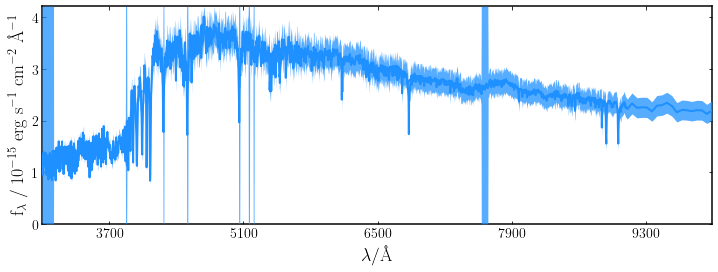


Results loaded from pipes/posterior/yirui_test_snap119_veldisp_off_NP2bins_simple/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_tauv1.0_mu0.3_119star_age.h5

Fitting not performed as results have already been loaded from pipes/posterior/yirui_test_snap119_veldisp_off_NP2bins_simple/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_tauv1.0_mu0.3_119star_age.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/yirui_test_snap119_veldisp_off_NP3bins_simple/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_tauv1.0_mu0.3_119star_age.h5

Fitting not performed as results have already been loaded from pipes/posterior/yirui_test_snap119_veldisp_off_NP3bins_simple/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_tauv1.0_mu0.3_119star_age.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/yirui_test_snap119_veldisp_off_NP4bins_simple/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_tauv1.0_mu0.3_119star_age.h5

Fitting not performed as results have already been loaded from pipes/posterior/yir

In [21]:
ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_tauv1.0_mu0.3_119star_age'
z = 0.04

galaxy = pipes.galaxy(ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

fits = {}
for Nbins in np.arange(2,16):
    runID = f"yirui_test_snap119_veldisp_off_NP{Nbins}bins_simple"
    fit = pipes.fit(galaxy, {}, run=runID)
    fit.fit(verbose=False)
    fits[str(Nbins)] = fit

### Comparing Iyer NP SFH fitted directly on the true SFH vs through the SED
Pay attention to how the locations of the bin boundaries differ between fitting directly on the true SFH and having to pass through the SED. The bin boundaries always shift towards more recent times since the mass formed in the galaxy's far distant history is often massively underestimated. Also note that the posterior total stellar mass of the galaxy is at most 60% that of the true mass. <br>

For error calculations for the Bagpipes fits, I used the same equation as previously used in other situations:
$\begin{equation}
\Big ( \sum_i^{Nbins} \int_{whole\;bin} (\rm{SFR}(age) - \bar{SFR}_i)^2 d(age) \Big )/(\bar{SFR}\cdot M_*)
\end{equation}$ <br> <br>
where $\bar{\rm{SFR}}_i$ is the calculated average SFR in bin i (can be from both the true SFH, in the case of calculating the binning error, or from the fitted SFH, in the case of calculating the fitting error). <br>

Here, two errors for bagpipes' fit are calculated, one is the median of the list of errors calculated for each SFH sample, and the other is the error calculated for the median SFH (median SFH takes the median at each time step to create a much more smooth SFH). <br>

Note that the current error statistic does not directly compare the bagpipes fitted SFH to the true SFH, but compares the true SFH to the average SFR in each bin as assigned by the bagpipes posterior SFH and bin boundaries. Ideally, a new error statistic that compares the fitted SFH to the true SFH that also takes into account the uncertainties along the fitted SFH is needed, but I am not sure how to define a good one.

In [331]:
def integrate_sfh(ages, sfh, Mstar=None):
    if Mstar is None:
        Mstar = np.trapz(y=sfh,x=ages)
    c_sfh = np.zeros(len(sfh))
    for i,sfhi in enumerate(sfh):
        c_sfh[i] = np.trapz(sfh[:i+1],x=ages[:i+1]/Mstar)
    return c_sfh

def compare_fits(Nbins, vb=False):
    # Iyer binning GP fit directly on true SFH
    tx = bin_iyer(Nbins)
    ave_sfr_ = cal_ave_sfr(model_ages, model_sfh, tx, age_at_z, abs_err=True)
    ave_sfr = ave_sfr_[:-1]
    if vb==True:
        print('(binning) summed squared arror between averaged sfr and actual sfh =', ave_sfr_[-1])

    iyer_sfh, iyer_ages, iyer_c_mass, iyer_sfh_var, iyer_c_mass_var, iyer_samples = db_fit(Nbins, tx)
    iyer_ave_sfr_ = cal_ave_sfr(iyer_ages, iyer_sfh, tx, age_at_z, abs_err=True, isfit=True)
    iyer_ave_sfr = iyer_ave_sfr_[:-1]
    if vb==True:
        print('(fitted) summed squared arror between averaged sfr and actual sfh =', iyer_ave_sfr_[-1])

    if vb==True:
        fig, ax = plt.subplots(2, 1, figsize=[15,10])
        p0 = ax[0].plot(model_ages, model_sfh, label='truth')
        ylims = ax[0].get_ylim()
        ax[0].vlines(tx*age_at_z, 0, ylims[1], color='k', ls='--')
        ax[0].hlines(*ave_sfr, color=p0[0].get_color(), ls='--', label='average SFR in bin', zorder=1)
        p1 = ax[0].plot(iyer_ages, iyer_sfh, label='GP fit')
        ax[0].hlines(*iyer_ave_sfr, color=p1[0].get_color(), ls='--', label='fitted SFR in bin', zorder=1)
        #ax[0].fill_between(iyer_ages, iyer_sfh-np.sqrt(iyer_sfh_var), iyer_sfh+np.sqrt(iyer_sfh_var), 
        #                  color='sandybrown', alpha=0.2)
        ax[0].set_xlim([0,age_at_z])
        ax[0].set_ylim([0,ylims[1]])
        ax[0].set_xlabel('age of Universe / Gyr')
        ax[0].set_ylabel(r'$SFR / M_{\odot} yr^{-1}$')
        ax[0].legend()
        ax[0].set_title(f'Iyer binning GP fit directly on true SFH - {Nbins} bins')

        ax[1].plot(model_ages, c_model_sfh, label='truth')
        ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', label='datapoints')
        ax[1].plot(iyer_ages, iyer_c_mass, label='GP fit')
        ax[1].fill_between(iyer_ages, iyer_c_mass-np.sqrt(iyer_c_mass_var), iyer_c_mass+np.sqrt(iyer_c_mass_var), 
                          color='sandybrown', alpha=0.2)
        ax[1].set_xlim([0,age_at_z])
        ax[1].set_xlabel('age of Universe / Gyr')
        ax[1].set_ylabel(r'cumulative mass formed / $\times 10^9\;M_{\odot}$')
        for samp in iyer_samples:
            ax[0].plot(iyer_ages, samp[0], color='k', alpha=0.1)
            ax[1].plot(iyer_ages, samp[1], color='k', alpha=0.1)
        ax[1].legend()
        plt.show()
    
    # Bagpipes Iyer fitting results through spectrum
    samples = fits[str(Nbins)].posterior.samples
    post_ages = age_at_z*10**9 - fits[str(Nbins)].posterior.sfh.ages[::-1]
    txs = samples['iyer2019:tx'].T
    tx_percentiles = []
    for i,txi in enumerate(txs):
        tx_percentiles.append(np.percentile(txi, (16,50,84)))
    tx_percentiles = np.array(tx_percentiles)
    median_sfh = np.median(samples["sfh"], axis=0).T[::-1]
    total_median_sfh_mass = np.trapz(median_sfh,x=post_ages)
    if vb==True:
        print('only recovered',total_median_sfh_mass/model_Mstar,'of total mass formed.')
    c_median_sfh = integrate_sfh(post_ages, median_sfh, Mstar=total_median_sfh_mass)
    
    #use custom GP to fit for all samples of txes (with GP samples) to get sfhs
    sfh_samps = []
    c_sfh_samps = []
    sample_ages = db_fit(Nbins, tx_percentiles[:,1]/age_at_z,sample=10, zval=z)[1]
    tx_len = len(samples['iyer2019:tx'])
    for i,txi in enumerate(samples['iyer2019:tx']):
        this_samples = db_fit(Nbins, txi/age_at_z,sample=100, zval=z)[5]
        sfh_samps.extend(this_samples[:,0,:])
        c_sfh_samps.extend(this_samples[:,1,:])
        if i%100 == 0:
            print(i,'/',tx_len)
    sfh_samps = np.array(sfh_samps)
    c_sfh_samps = np.array(c_sfh_samps)
    samp_median_sfh = np.percentile(sfh_samps, (16,50,84), axis=0)
    samp_median_c_sfh = np.percentile(c_sfh_samps, (16,50,84), axis=0)
    print(np.shape(samp_median_sfh))

    #average sfr and error statistics
    post_sq_errs = np.zeros(len(samples['sfh']))
    for i,sample_sfh in enumerate(samples['sfh']):
        post_sq_errs[i] = cal_ave_sfr(post_ages/10**9, sample_sfh[::-1], samples['iyer2019:tx'][i]/age_at_z, age_at_z, 
                                      abs_err=True, isfit=True)[-1]
    if vb==True:
        print('median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh =', np.median(post_sq_errs))
    median_ave_sfr_ = cal_ave_sfr(post_ages/10**9, median_sfh, tx_percentiles[:,1]/age_at_z, age_at_z, abs_err=True, isfit=True)
    median_ave_sfr = median_ave_sfr_[:-1]
    if vb==True:
        print('(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh =', median_ave_sfr_[-1])
    
    if vb==True:
        fig, ax = plt.subplots(2, 1, figsize=[15,10])
        p0 = ax[0].plot(model_ages, model_sfh, label='truth')
        ylims = ax[0].get_ylim()
        pipes.plotting.add_sfh_posterior(fits[str(Nbins)], ax[0], colorscheme='irnbru', label='posterior GP fit')
        ax[0].plot(sample_ages, samp_median_sfh[1], color='green', label='sample median',zorder=2)
        ax[0].fill_between(sample_ages, samp_median_sfh[0], samp_median_sfh[2], color='lightgreen', alpha=0.4, zorder=1)
        #ax[0].hlines(*median_ave_sfr, color='green', ls='--', label='fitted SFR in bin', zorder=1)
        for i,[l,m,u] in enumerate(tx_percentiles):
            ax[0].vlines(m, 0, ylims[1], color = 'k', ls='--', alpha=0.5)
            ax[0].fill_betweenx([0,ylims[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5, zorder=0)
        for i in np.random.randint(0,len(sfh_samps), size=20):
            ax[0].plot(sample_ages, sfh_samps[i], color='k', alpha=0.1)
            ax[1].plot(sample_ages, c_sfh_samps[i], color='k', alpha=0.1, zorder=-1)
        ax[0].set_xlim(ax[0].get_xlim()[::-1])
        ax[0].legend()
        ax[0].set_title(f'Iyer binning GP fit by Bagpipes through SED - {Nbins} bins')

        ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=1)
        ax[1].plot(post_ages/10**9, c_median_sfh, label='posterior GP fit', zorder=1)
        ax[1].plot(sample_ages, samp_median_c_sfh[1], color='green', label='sample median', zorder=2)
        ax[1].fill_between(sample_ages, samp_median_c_sfh[0], samp_median_c_sfh[2], color='lightgreen', alpha=0.4, zorder=1)
        ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,Nbins+1)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                                  tx_percentiles[:,2]-tx_percentiles[:,1]],
                      color='k', label='posterior bin boundaries', fmt='o')
        ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', marker='o', label='truth bin boundaries', alpha=0.4)
        ax[1].set_xlim([0,age_at_z])
        ax[1].set_xlabel('age of Universe / Gyr')
        ax[1].set_ylabel(r'cumulative mass formed / $\times 10^9\;M_{\odot}$')
        ax[1].legend()
        plt.show()
        print(max(sample_ages), max(post_ages/10**9))
    
    return ave_sfr_[-1], iyer_ave_sfr_[-1], np.median(post_sq_errs), median_ave_sfr_[-1]

(binning) summed squared arror between averaged sfr and actual sfh = 0.6033179812754755
(fitted) summed squared arror between averaged sfr and actual sfh = 0.6034078752205579


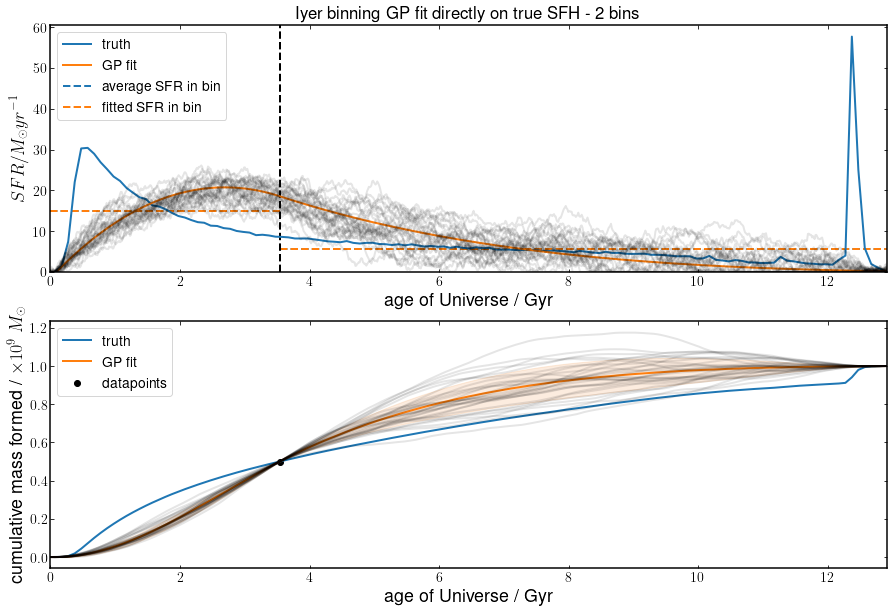

only recovered 0.6708035961378971 of total mass formed.
0 / 2057
100 / 2057
200 / 2057
300 / 2057
400 / 2057
500 / 2057
600 / 2057
700 / 2057
800 / 2057
900 / 2057
1000 / 2057
1100 / 2057
1200 / 2057
1300 / 2057
1400 / 2057
1500 / 2057
1600 / 2057
1700 / 2057
1800 / 2057
1900 / 2057
2000 / 2057
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.1406542672103392
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.1406667532519994


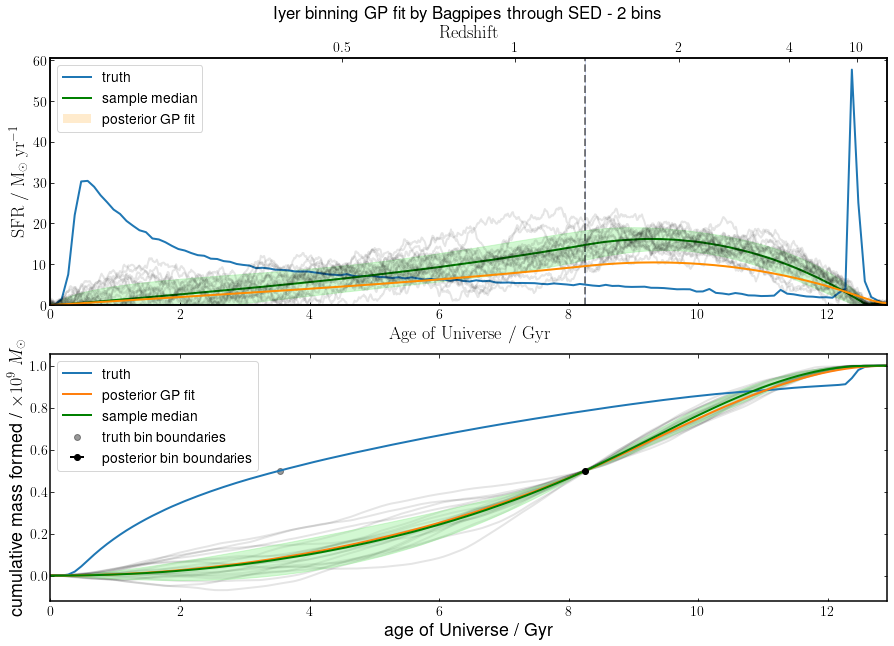

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.5387227079902448
(fitted) summed squared arror between averaged sfr and actual sfh = 0.5389743156008209


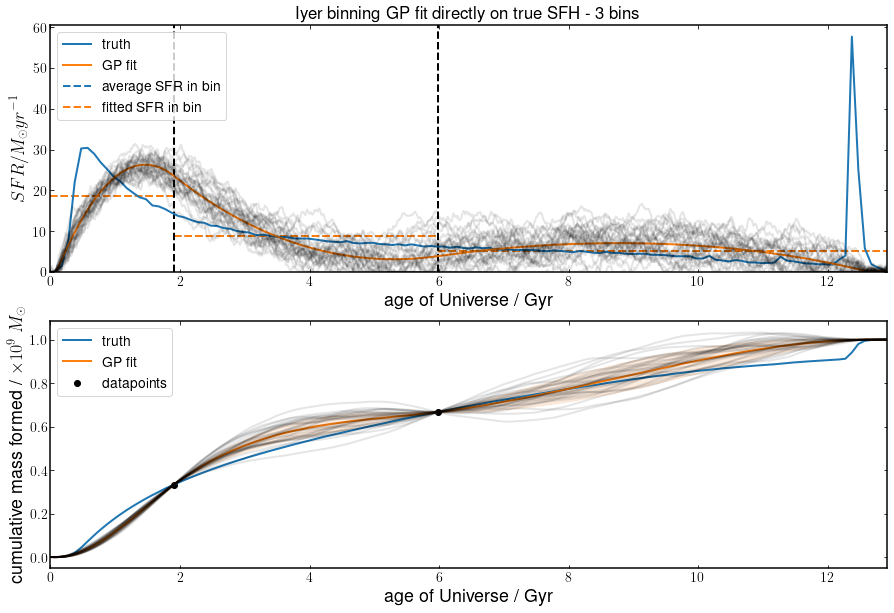

only recovered 0.3889484041686052 of total mass formed.
0 / 3324
100 / 3324
200 / 3324
300 / 3324
400 / 3324
500 / 3324
600 / 3324
700 / 3324
800 / 3324
900 / 3324
1000 / 3324
1100 / 3324
1200 / 3324
1300 / 3324
1400 / 3324
1500 / 3324
1600 / 3324
1700 / 3324
1800 / 3324
1900 / 3324
2000 / 3324
2100 / 3324
2200 / 3324
2300 / 3324
2400 / 3324
2500 / 3324
2600 / 3324
2700 / 3324
2800 / 3324
2900 / 3324
3000 / 3324
3100 / 3324
3200 / 3324
3300 / 3324
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.3426708632400657
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.3407771699696127


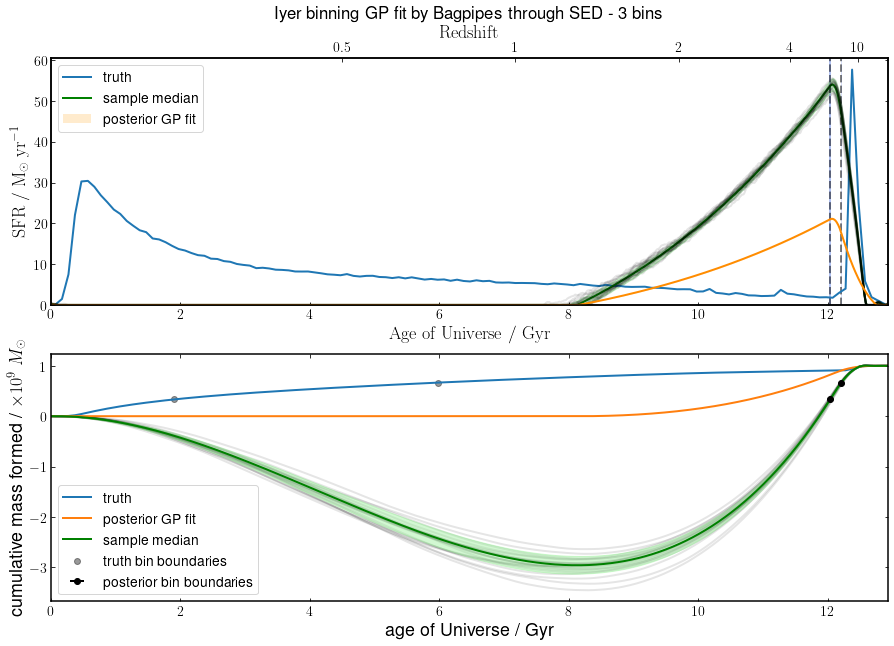

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.5341934060602763
(fitted) summed squared arror between averaged sfr and actual sfh = 0.5345056559988359


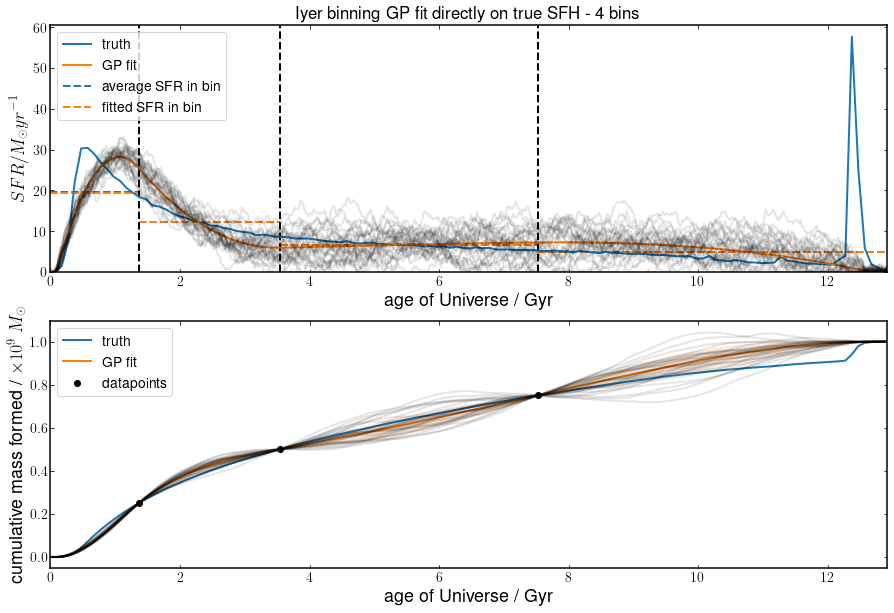

only recovered 0.3910955698865278 of total mass formed.
0 / 2399
100 / 2399
200 / 2399
300 / 2399
400 / 2399
500 / 2399
600 / 2399
700 / 2399
800 / 2399
900 / 2399
1000 / 2399
1100 / 2399
1200 / 2399
1300 / 2399
1400 / 2399
1500 / 2399
1600 / 2399
1700 / 2399
1800 / 2399
1900 / 2399
2000 / 2399
2100 / 2399
2200 / 2399
2300 / 2399
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.5643833707940495
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.5121314772431351


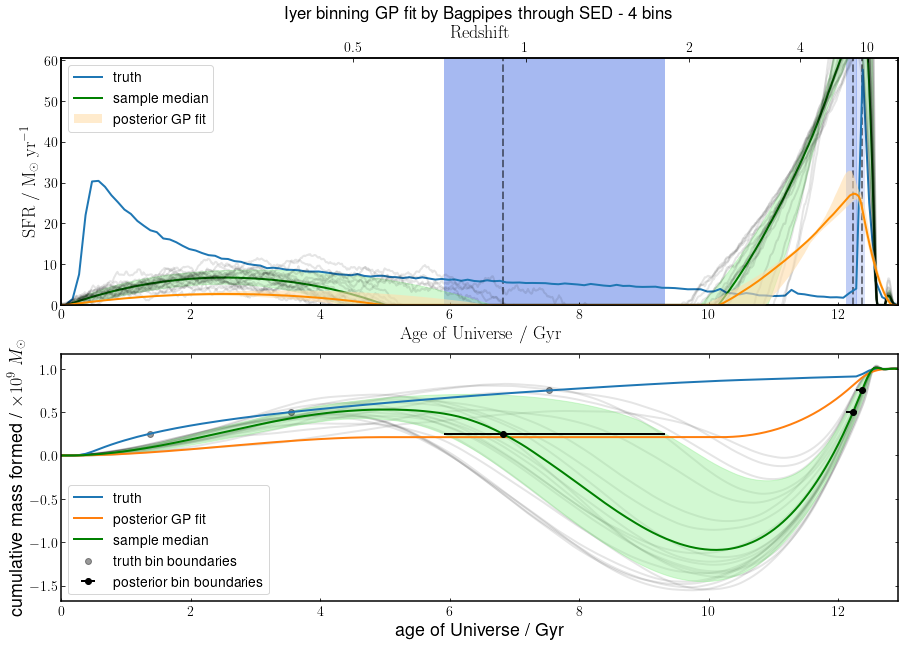

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.5266922025654625
(fitted) summed squared arror between averaged sfr and actual sfh = 0.5271339422484942


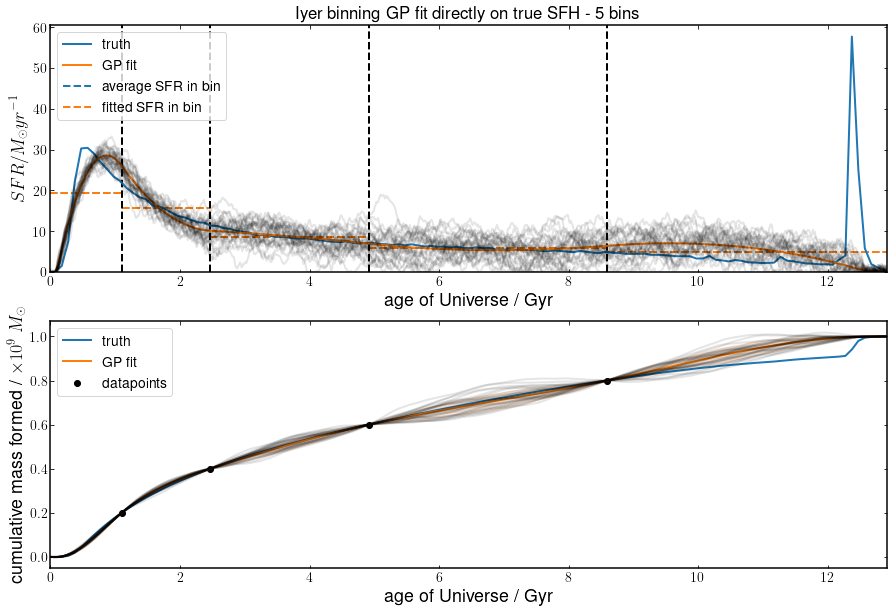

only recovered 0.5045978987090148 of total mass formed.
0 / 1157
100 / 1157
200 / 1157
300 / 1157
400 / 1157
500 / 1157
600 / 1157
700 / 1157
800 / 1157
900 / 1157
1000 / 1157
1100 / 1157
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.2093294190616848
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.0765975228251485


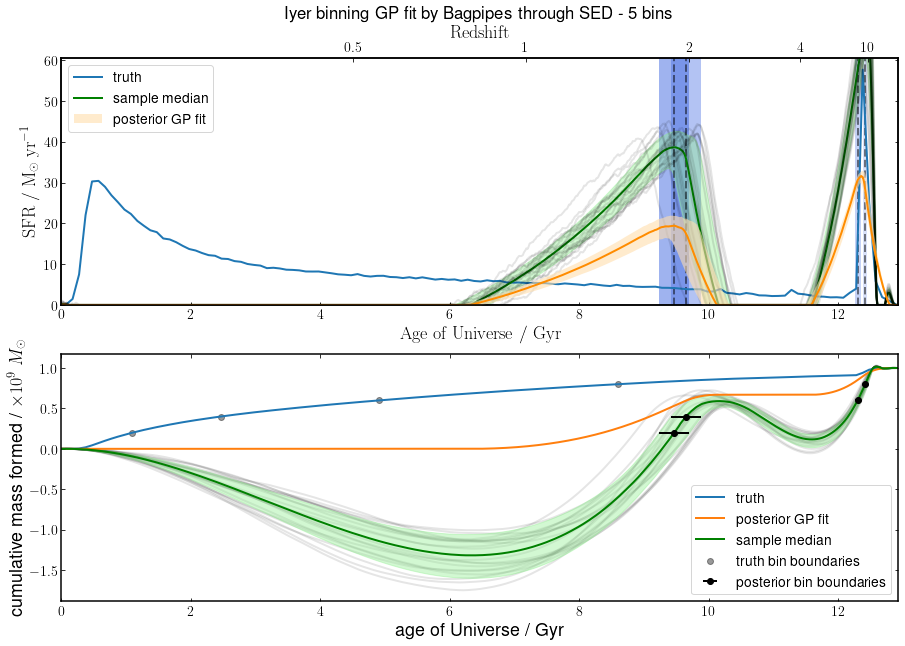

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.5237698733662081
(fitted) summed squared arror between averaged sfr and actual sfh = 0.5241907409143391


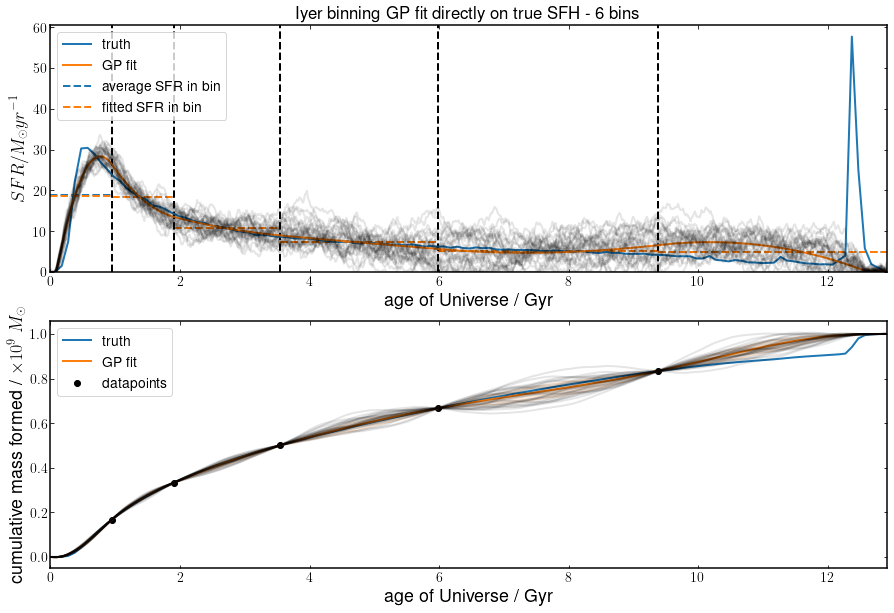

only recovered 0.5370480450298545 of total mass formed.
0 / 4967
100 / 4967
200 / 4967
300 / 4967
400 / 4967
500 / 4967
600 / 4967
700 / 4967
800 / 4967
900 / 4967
1000 / 4967
1100 / 4967
1200 / 4967
1300 / 4967
1400 / 4967
1500 / 4967
1600 / 4967
1700 / 4967
1800 / 4967
1900 / 4967
2000 / 4967
2100 / 4967
2200 / 4967
2300 / 4967
2400 / 4967
2500 / 4967
2600 / 4967
2700 / 4967
2800 / 4967
2900 / 4967
3000 / 4967
3100 / 4967
3200 / 4967
3300 / 4967
3400 / 4967
3500 / 4967
3600 / 4967
3700 / 4967
3800 / 4967
3900 / 4967
4000 / 4967
4100 / 4967
4200 / 4967
4300 / 4967
4400 / 4967
4500 / 4967
4600 / 4967
4700 / 4967
4800 / 4967
4900 / 4967
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.6219788726971522
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.5099514417479196


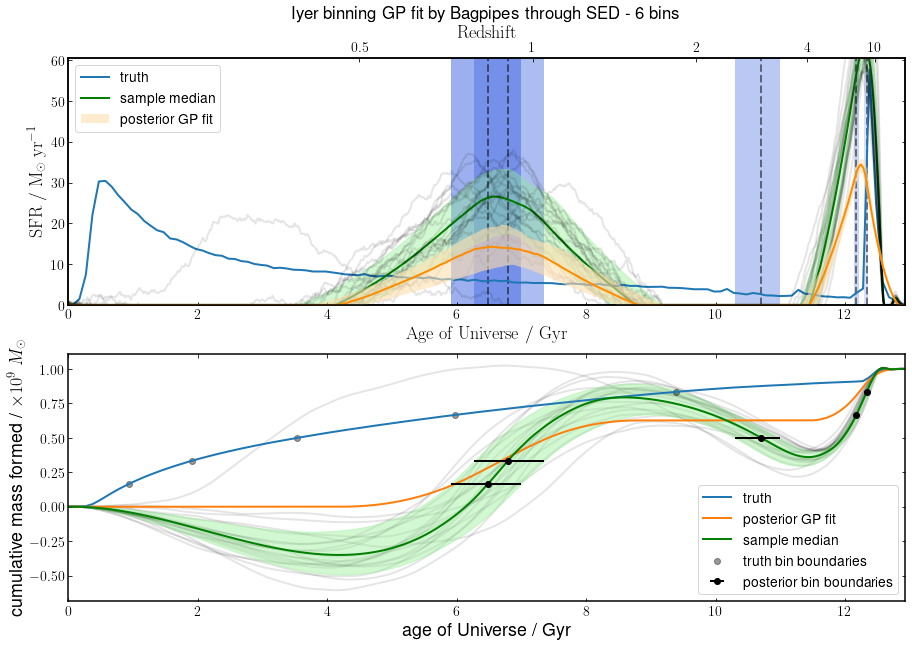

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.517304141144593
(fitted) summed squared arror between averaged sfr and actual sfh = 0.5177577620174181


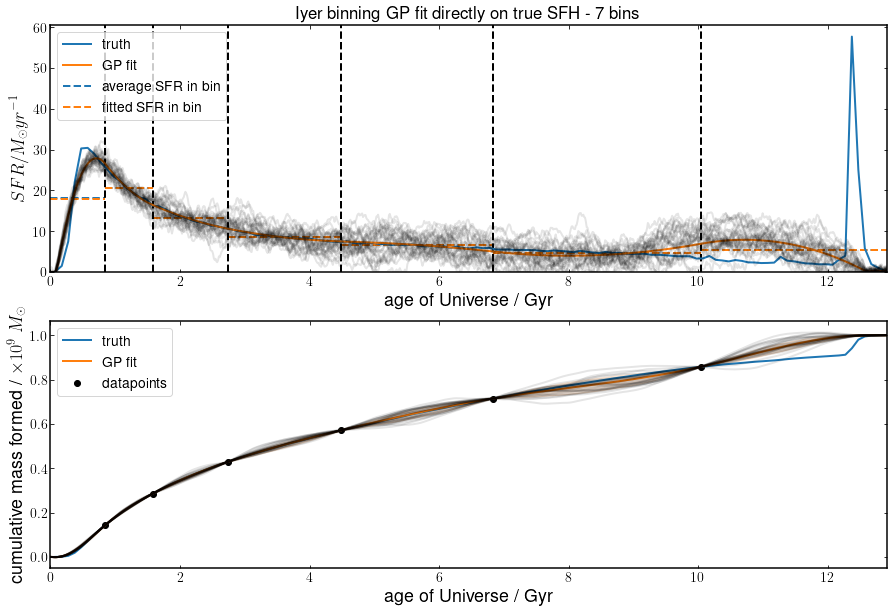

only recovered 0.4474738994269967 of total mass formed.
0 / 2358
100 / 2358
200 / 2358
300 / 2358
400 / 2358
500 / 2358
600 / 2358
700 / 2358
800 / 2358
900 / 2358
1000 / 2358
1100 / 2358
1200 / 2358
1300 / 2358
1400 / 2358
1500 / 2358
1600 / 2358
1700 / 2358
1800 / 2358
1900 / 2358
2000 / 2358
2100 / 2358
2200 / 2358
2300 / 2358
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.5229991403948602
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.5360981824270559


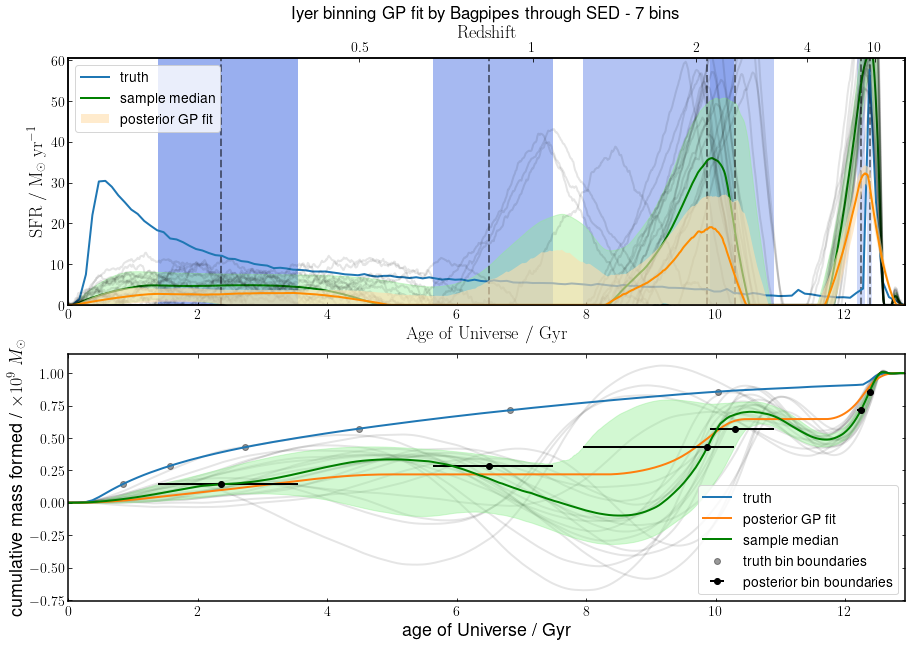

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.5040622398431767
(fitted) summed squared arror between averaged sfr and actual sfh = 0.5042649345808937


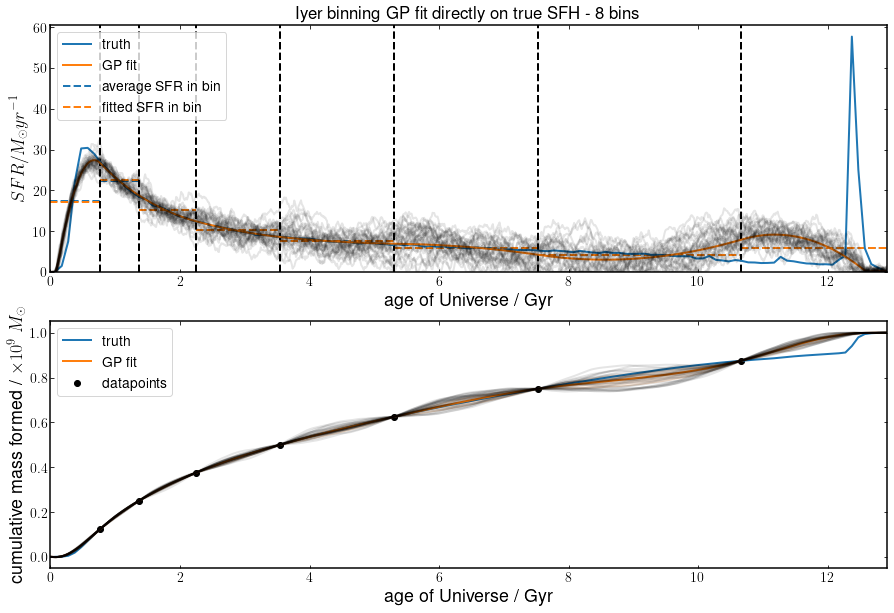

only recovered 0.40099124224703114 of total mass formed.
0 / 3341
100 / 3341
200 / 3341
300 / 3341
400 / 3341
500 / 3341
600 / 3341
700 / 3341
800 / 3341
900 / 3341
1000 / 3341
1100 / 3341
1200 / 3341
1300 / 3341
1400 / 3341
1500 / 3341
1600 / 3341
1700 / 3341
1800 / 3341
1900 / 3341
2000 / 3341
2100 / 3341
2200 / 3341
2300 / 3341
2400 / 3341
2500 / 3341
2600 / 3341
2700 / 3341
2800 / 3341
2900 / 3341
3000 / 3341
3100 / 3341
3200 / 3341
3300 / 3341
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.5516182615275573
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.4783420942106722


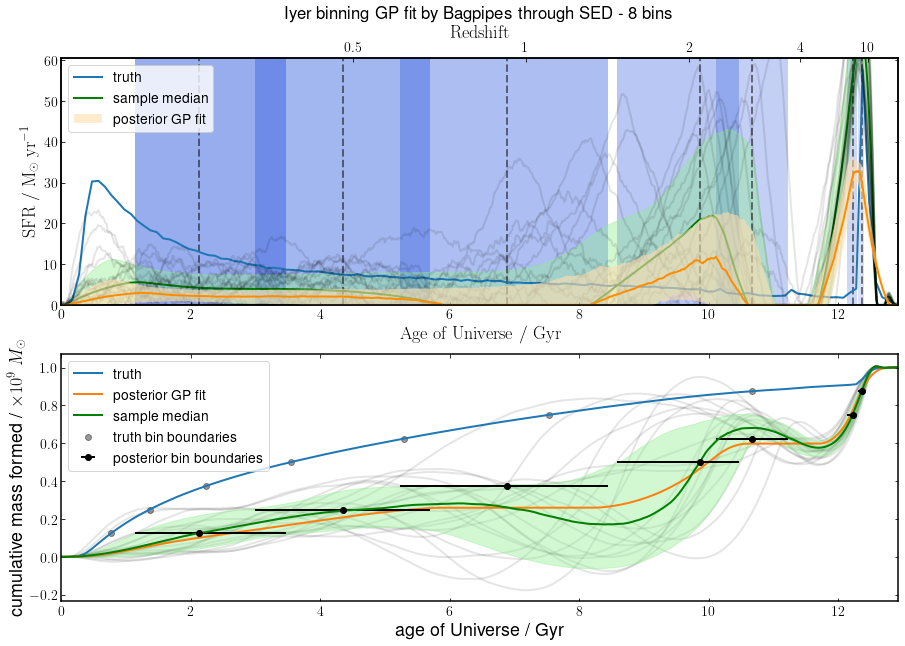

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.49103000891197923
(fitted) summed squared arror between averaged sfr and actual sfh = 0.4916059276568328


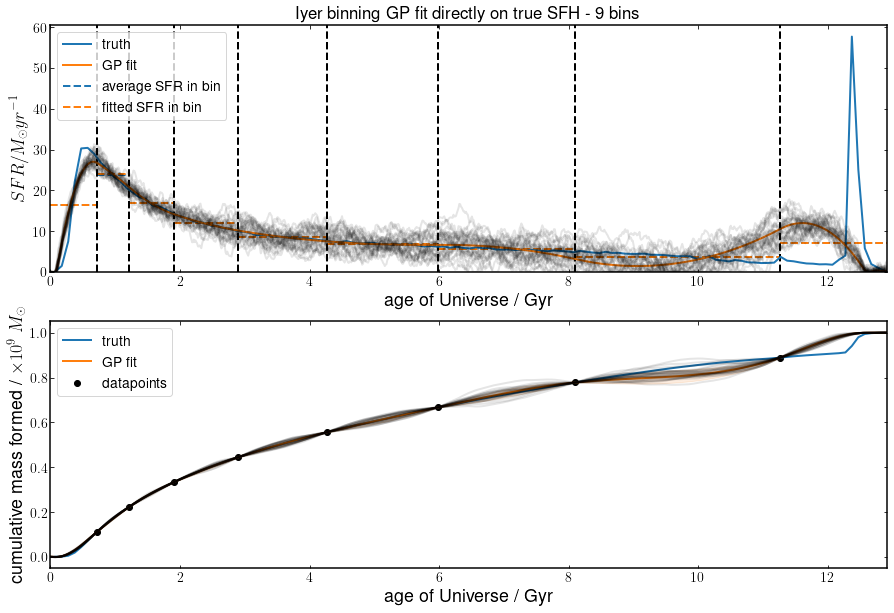

only recovered 0.428241116072762 of total mass formed.
0 / 3034
100 / 3034
200 / 3034
300 / 3034
400 / 3034
500 / 3034
600 / 3034
700 / 3034
800 / 3034
900 / 3034
1000 / 3034
1100 / 3034
1200 / 3034
1300 / 3034
1400 / 3034
1500 / 3034
1600 / 3034
1700 / 3034
1800 / 3034
1900 / 3034
2000 / 3034
2100 / 3034
2200 / 3034
2300 / 3034
2400 / 3034
2500 / 3034
2600 / 3034
2700 / 3034
2800 / 3034
2900 / 3034
3000 / 3034
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.5378297674535988
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.4626249488886183


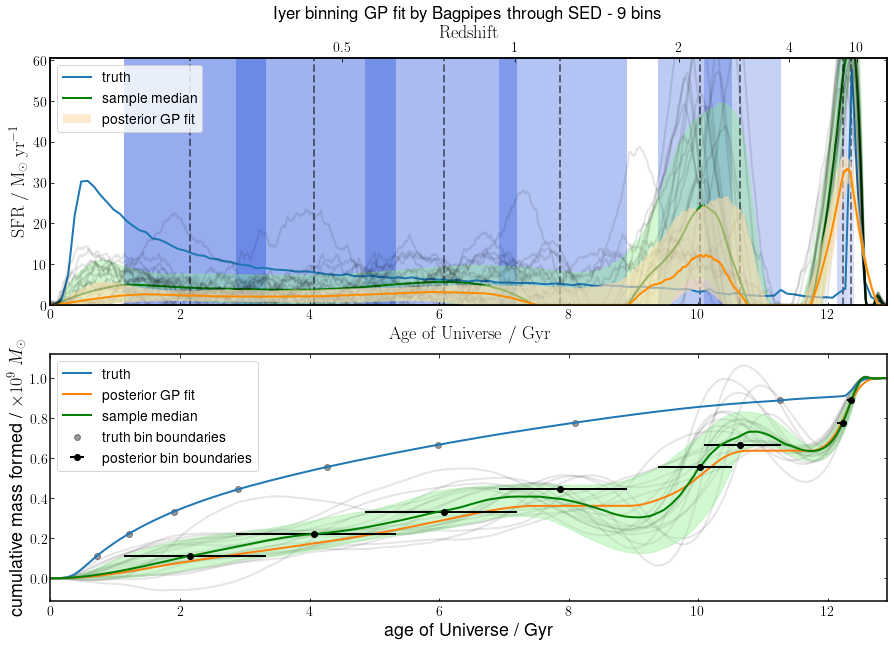

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.4752386759024874
(fitted) summed squared arror between averaged sfr and actual sfh = 0.4760903455885103


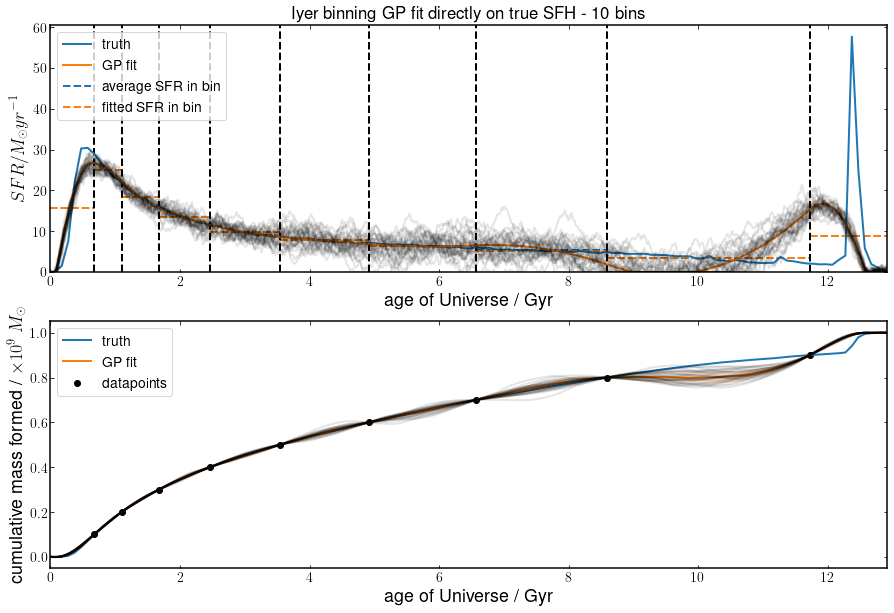

only recovered 0.48390694601195294 of total mass formed.
0 / 2730
100 / 2730
200 / 2730
300 / 2730
400 / 2730
500 / 2730
600 / 2730
700 / 2730
800 / 2730
900 / 2730
1000 / 2730
1100 / 2730
1200 / 2730
1300 / 2730
1400 / 2730
1500 / 2730
1600 / 2730
1700 / 2730
1800 / 2730
1900 / 2730
2000 / 2730
2100 / 2730
2200 / 2730
2300 / 2730
2400 / 2730
2500 / 2730
2600 / 2730
2700 / 2730
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.4521255399951554
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.3997735328082295


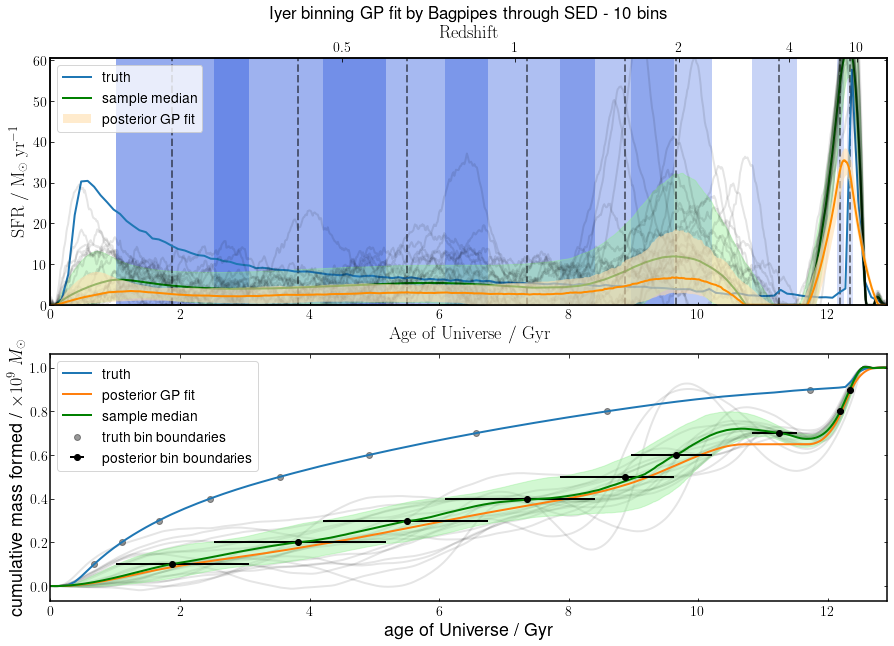

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.40613579082287715
(fitted) summed squared arror between averaged sfr and actual sfh = 0.44434636193371263


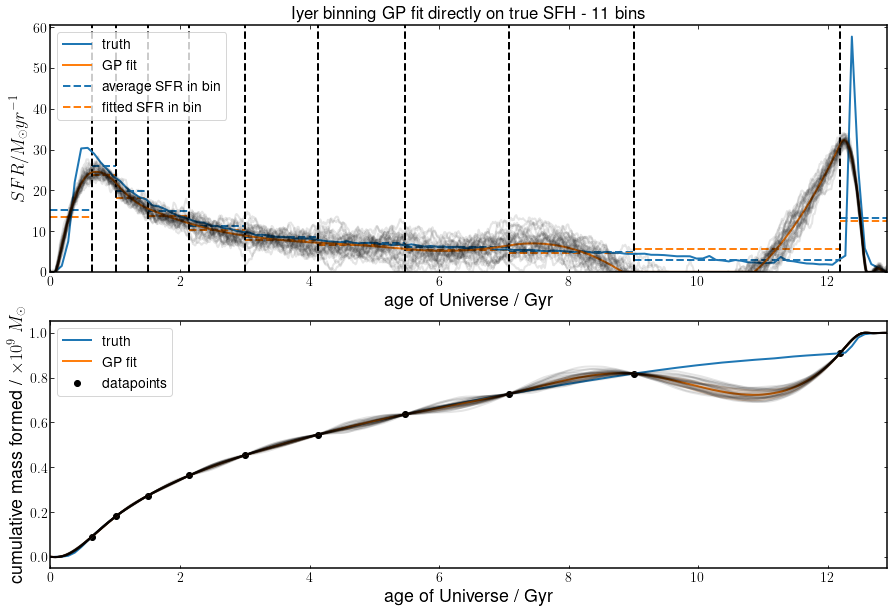

only recovered 0.5143366692565632 of total mass formed.
0 / 2262
100 / 2262
200 / 2262
300 / 2262
400 / 2262
500 / 2262
600 / 2262
700 / 2262
800 / 2262
900 / 2262
1000 / 2262
1100 / 2262
1200 / 2262
1300 / 2262
1400 / 2262
1500 / 2262
1600 / 2262
1700 / 2262
1800 / 2262
1900 / 2262
2000 / 2262
2100 / 2262
2200 / 2262
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.3285357707024743
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.3329170125679384


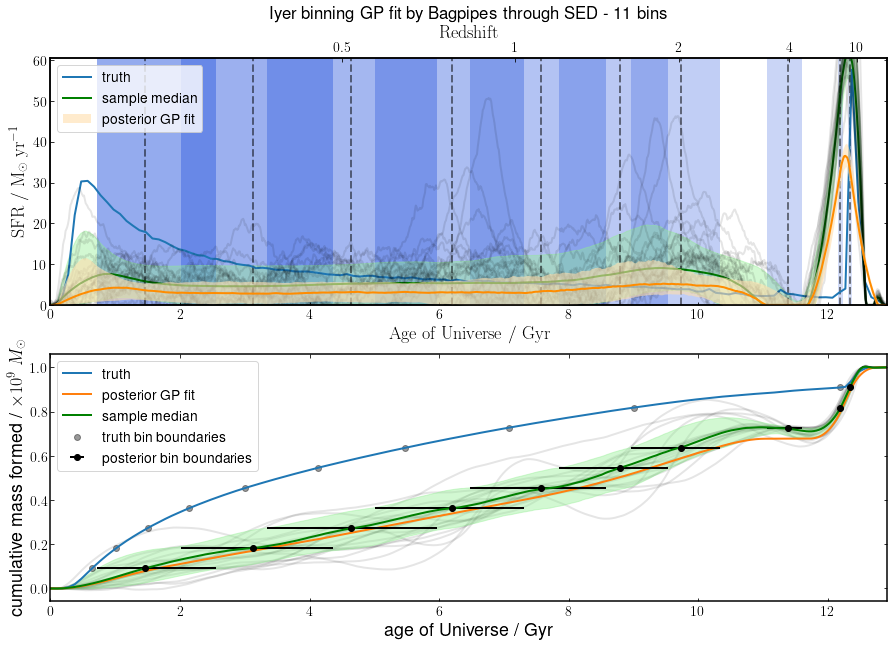

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.3913265303498401
(fitted) summed squared arror between averaged sfr and actual sfh = 0.4713148199050552


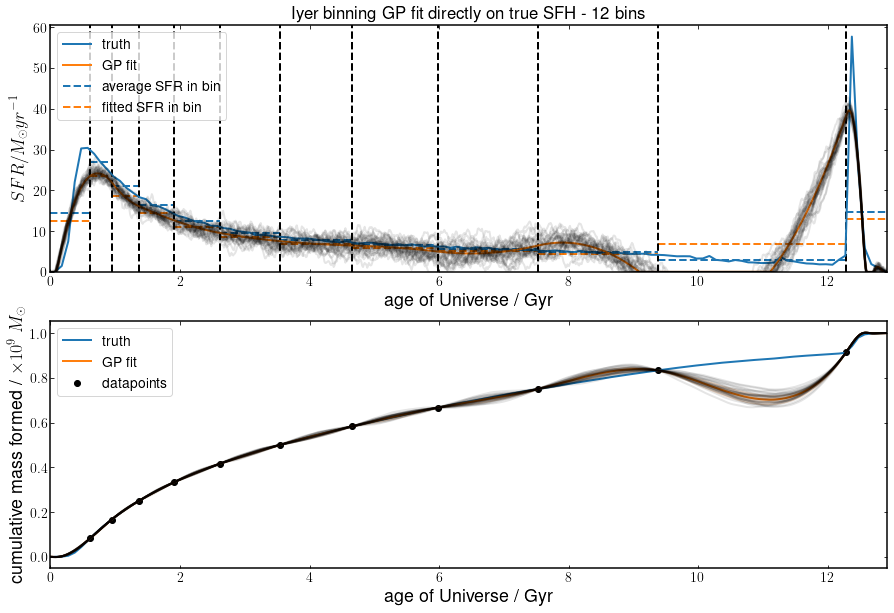

only recovered 0.5323338847499991 of total mass formed.
0 / 2173
100 / 2173
200 / 2173
300 / 2173
400 / 2173
500 / 2173
600 / 2173
700 / 2173
800 / 2173
900 / 2173
1000 / 2173
1100 / 2173
1200 / 2173
1300 / 2173
1400 / 2173
1500 / 2173
1600 / 2173
1700 / 2173
1800 / 2173
1900 / 2173
2000 / 2173
2100 / 2173
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.2792444019382845
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.3084783368331014


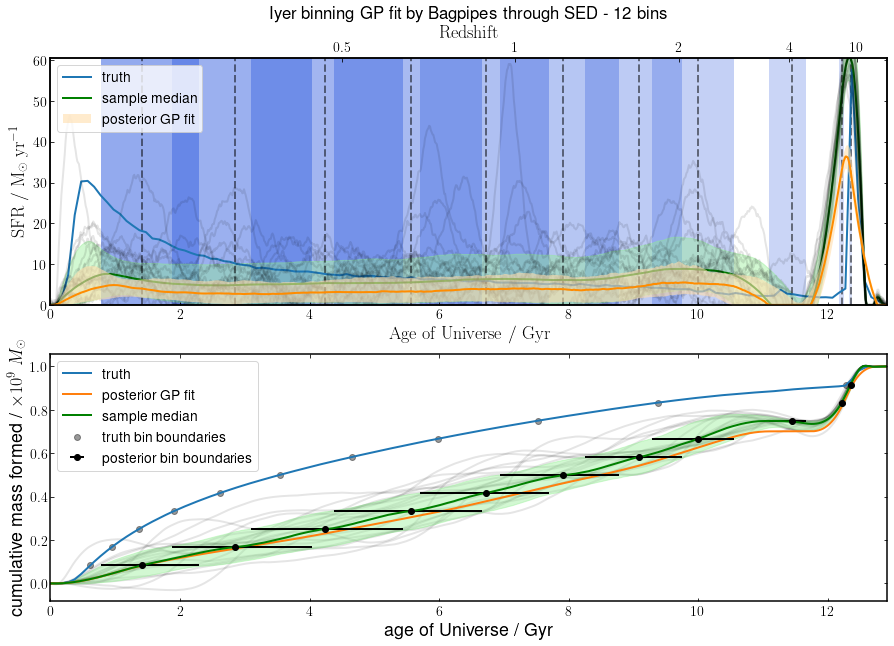

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.39264060111402427
(fitted) summed squared arror between averaged sfr and actual sfh = 0.47184193419776593


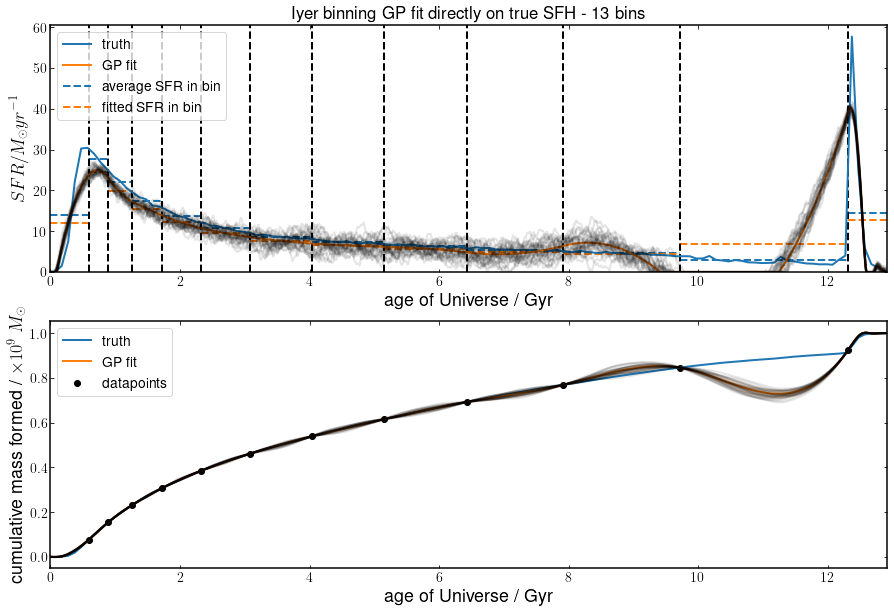

only recovered 0.5379772139054128 of total mass formed.
0 / 2093
100 / 2093
200 / 2093
300 / 2093
400 / 2093
500 / 2093
600 / 2093
700 / 2093
800 / 2093
900 / 2093
1000 / 2093
1100 / 2093
1200 / 2093
1300 / 2093
1400 / 2093
1500 / 2093
1600 / 2093
1700 / 2093
1800 / 2093
1900 / 2093
2000 / 2093
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.2335421941955915
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.275692881038705


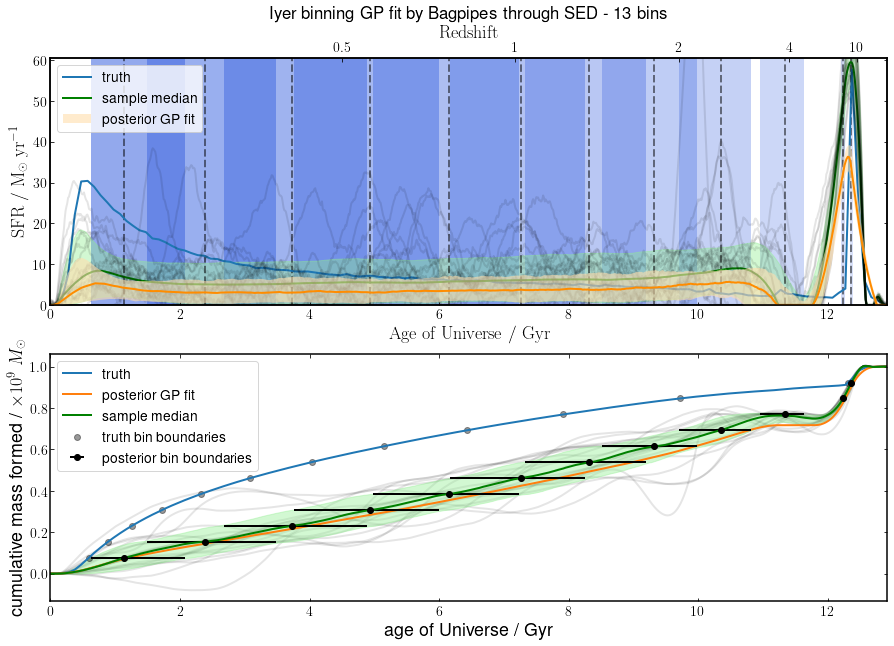

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.3631386763263293
(fitted) summed squared arror between averaged sfr and actual sfh = 0.4384847098701364


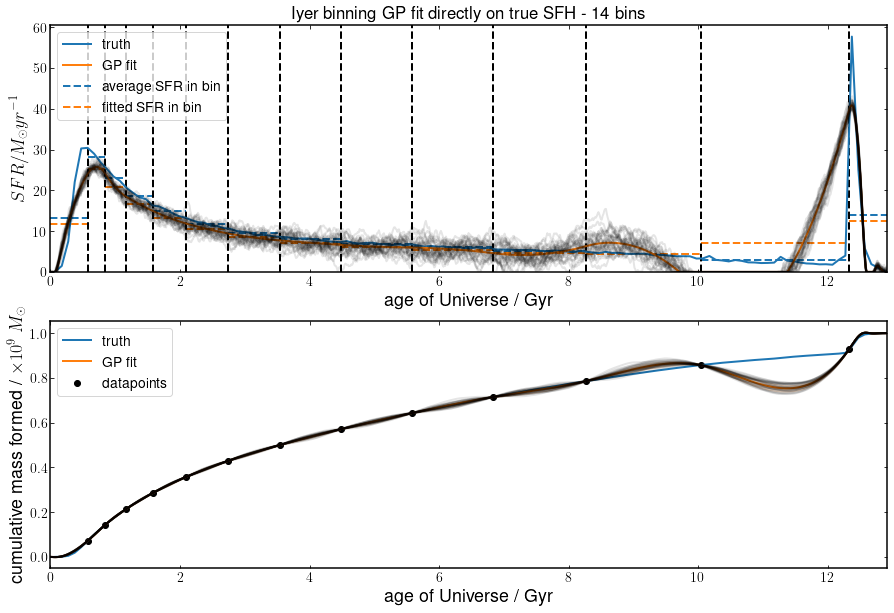

only recovered 0.5375259664106024 of total mass formed.
0 / 2046
100 / 2046
200 / 2046
300 / 2046
400 / 2046
500 / 2046
600 / 2046
700 / 2046
800 / 2046
900 / 2046
1000 / 2046
1100 / 2046
1200 / 2046
1300 / 2046
1400 / 2046
1500 / 2046
1600 / 2046
1700 / 2046
1800 / 2046
1900 / 2046
2000 / 2046
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.1695130384707646
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 1.0746383383464462


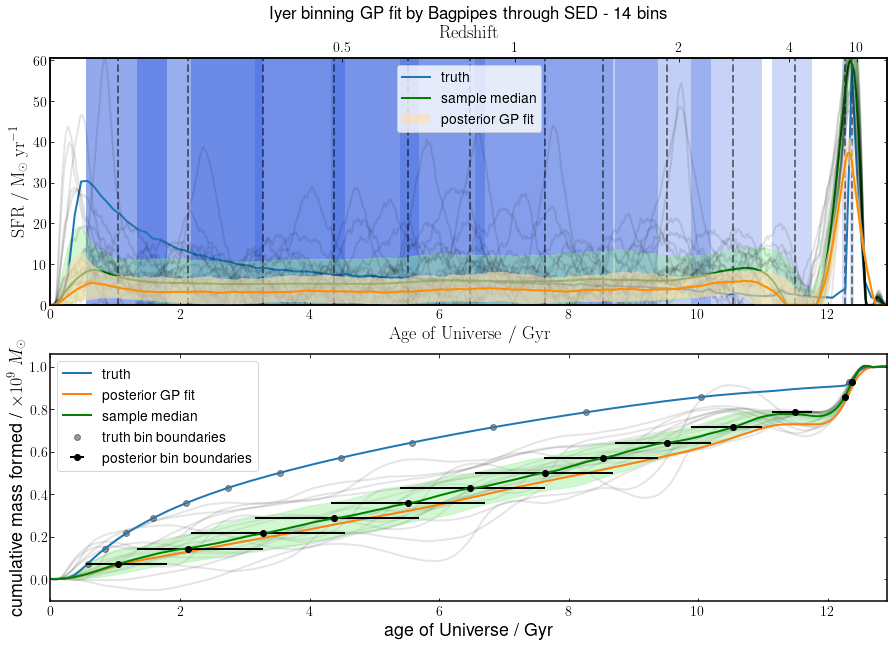

12.924069744375966 12.923069744375967
(binning) summed squared arror between averaged sfr and actual sfh = 0.36599166480387085
(fitted) summed squared arror between averaged sfr and actual sfh = 0.4365554401555091


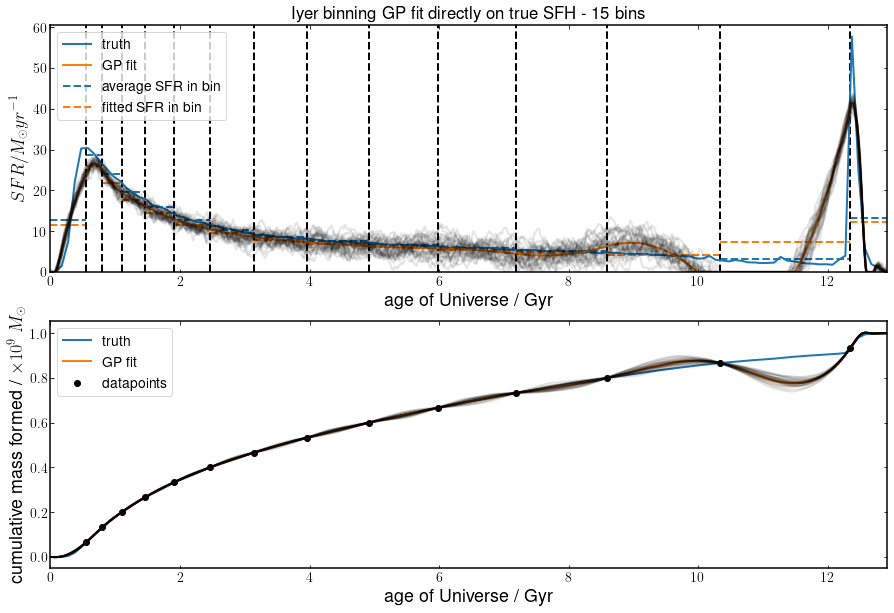

only recovered 0.5512016562861499 of total mass formed.
0 / 2045
100 / 2045
200 / 2045
300 / 2045
400 / 2045
500 / 2045
600 / 2045
700 / 2045
800 / 2045
900 / 2045
1000 / 2045
1100 / 2045
1200 / 2045
1300 / 2045
1400 / 2045
1500 / 2045
1600 / 2045
1700 / 2045
1800 / 2045
1900 / 2045
2000 / 2045
(3, 1000)
median (spectrum-fitted) summed squared arror between averaged sfr and actual sfh = 1.1369026215152749
(spectrum-fitted) summed squared arror between of median averaged sfr and actual sfh = 0.9180969408664592


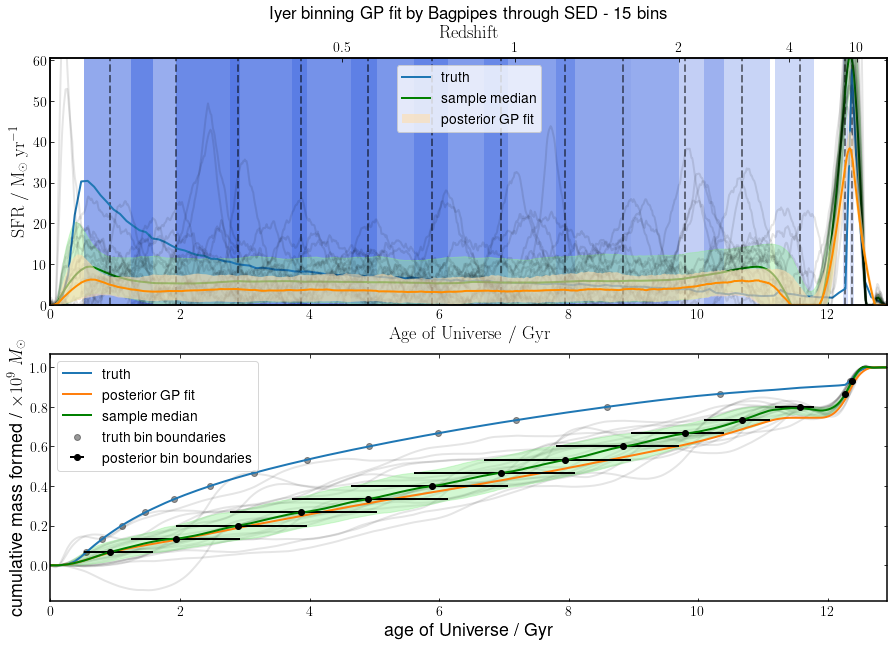

12.924069744375966 12.923069744375967


In [332]:
errors = []
for Nbins in np.arange(2,16):
    errors.append(compare_fits(Nbins, vb=True))
    print('==============================================================')
errors = np.array(errors)

### Comparing the calculated error statistics

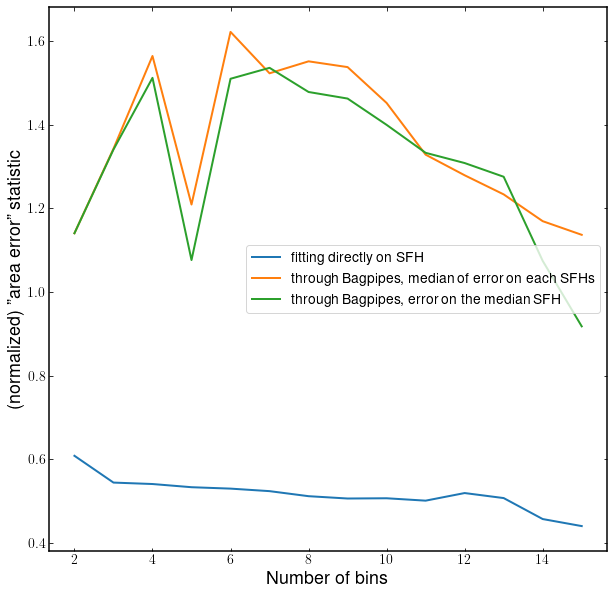

In [158]:
fig, ax = plt.subplots(figsize=[10,10])
ax.plot(np.arange(2,16), errors[:,1], label='fitting directly on SFH')
ax.plot(np.arange(2,16), errors[:,2], label='through Bagpipes, median of error on each SFHs')
ax.plot(np.arange(2,16), errors[:,3], label='through Bagpipes, error on the median SFH')
ax.set_xlabel('Number of bins')
ax.set_ylabel('(normalized) "area error" statistic')
ax.legend()
plt.show()

### Equivilent tx for parametric results
There seems to be an issue with the above NP fitted SFHs that the mass formed in the early half of the galaxy's history is horribly under estimated and yet the uncertainties on the fitted GPs do not reflect this intrinsic uncertainty when using the spectrum to date the SFH (called outshining). To verify if this is an issue unique to Iyer's binning scheme's implementation in Bagpipes, we measure the equivilent time bin boundaries (tx) for the parametric fits.

In [160]:
runID = "yirui_test_snap119_veldisp_off"
fit = pipes.fit(galaxy, {}, run=runID)
fit.fit(verbose=False)


Results loaded from pipes/posterior/yirui_test_snap119_veldisp_off/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_tauv1.0_mu0.3_119star_age.h5

Fitting not performed as results have already been loaded from pipes/posterior/yirui_test_snap119_veldisp_off/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_tauv1.0_mu0.3_119star_age.h5. To start over delete this file or change run.



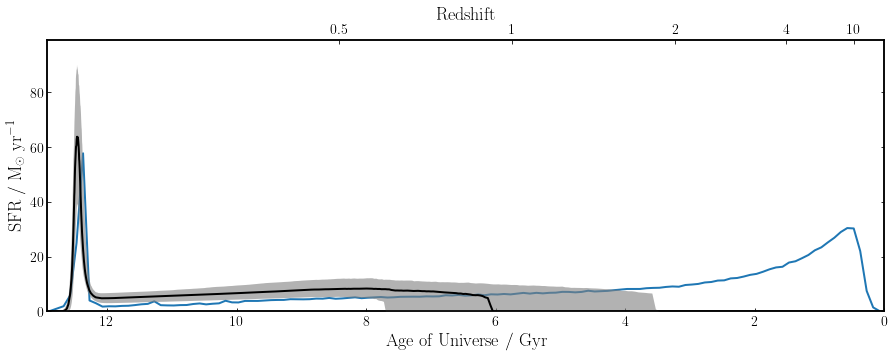

In [162]:
fig, ax = plt.subplots(1,1, figsize=[15,5])
pipes.plotting.add_sfh_posterior(fit, ax)
ax.plot(model_ages, model_sfh)#/(model_m_total/post_m_total))
ylim = ax.get_ylim()
plt.show()

only recovered 0.4825921915280268 of total mass formed.
[0.25 0.5  0.75]
[[ 5.18338275  7.34468336  8.74759575]
 [ 7.3226582   9.00304812 10.06267972]
 [10.55341764 11.4136732  11.82736543]]


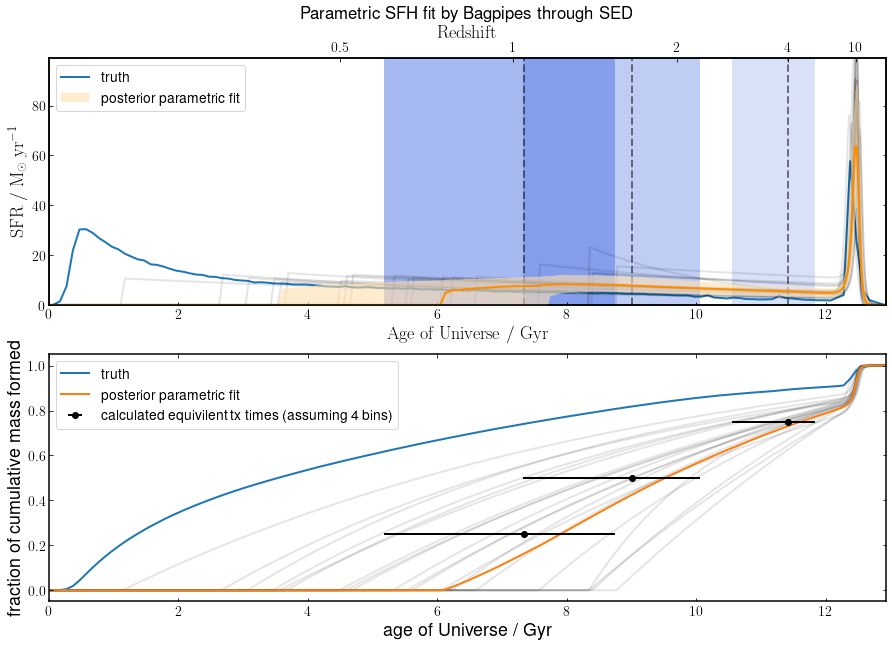

In [182]:
post_ages = age_at_z*10**9 - fit.posterior.sfh.ages[::-1]
median_sfh = np.median(fit.posterior.samples["sfh"], axis=0).T[::-1]
total_median_sfh_mass = np.trapz(median_sfh,x=post_ages)
print('only recovered',total_median_sfh_mass/model_Mstar,'of total mass formed.')
c_median_sfh = integrate_sfh(post_ages, median_sfh, Mstar=total_median_sfh_mass)
#calculating tx and their uncertainties
mass_percentiles = np.linspace(0,1,5)[1:-1]
print(mass_percentiles)
txs = []
for sfh_sample in fit.posterior.samples['sfh']:
    sfh_ = sfh_sample[::-1]
    c_sfh_ = integrate_sfh(post_ages, sfh_)
    txs.append(np.interp(mass_percentiles, c_sfh_, post_ages))
txs = (np.array(txs)/10**9).T
tx_percentiles = []
for i,txi in enumerate(txs):
    tx_percentiles.append(np.percentile(txi, (16,50,84)))
tx_percentiles = np.array(tx_percentiles)
print(tx_percentiles)
#10 random samples
sfh_samps = []
for i in np.random.randint(len(fit.posterior.samples['sfr']), size=20):
    sfh_samp = {}
    sfh_samp['sfh'] = fit.posterior.samples['sfh'][i][::-1]
    sfh_samp['c_sfh'] = integrate_sfh(post_ages, fit.posterior.samples['sfh'][i][::-1])
    sfh_samps.append(sfh_samp)
    
fig, ax = plt.subplots(2, 1, figsize=[15,10])
p0 = ax[0].plot(model_ages, model_sfh, label='truth')
ylims = ax[0].get_ylim()
pipes.plotting.add_sfh_posterior(fit, ax[0], colorscheme='irnbru', label='posterior parametric fit')
for i,[l,m,u] in enumerate(tx_percentiles):
    ax[0].vlines(m, 0, 10*ylims[1], color = 'k', ls='--', alpha=0.5)
    ax[0].fill_betweenx([0,10*ylims[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
for sfh_samp in sfh_samps:
    ax[0].plot(post_ages/10**9, sfh_samp['sfh'], color='k', alpha=0.1)
ax[0].set_xlim(ax[0].get_xlim()[::-1])
ax[0].legend()
ax[0].set_title(f'Parametric SFH fit by Bagpipes through SED')

ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=1)
ax[1].plot(post_ages/10**9, c_median_sfh, label='posterior parametric fit', zorder=1)
ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,4+1)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                          tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='k', label='calculated equivilent tx times (assuming 4 bins)', fmt='o')
#ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', marker='o', label='truth bin boundaries', alpha=0.4)
for sfh_samp in sfh_samps:
    ax[1].plot(post_ages/10**9, sfh_samp['c_sfh'], color='k', alpha=0.1, zorder=-1)
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel(r'fraction of cumulative mass formed')
ax[1].legend()
plt.show()

### dust might be an issue here, how about a fit without dust?

In [227]:
def load_uds_spectrum_mask_no_dust(ID,z):

    # load spectral data
    spectrum = np.loadtxt(fname="Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_"+ID+".csv", delimiter=',', skiprows=1)
    
    spectrum[:,1] *= 10**-16
    spectrum[:,2] *= 10**-16

    # blow up the errors associated with any bad points in the spectrum and photometry
    for i in range(len(spectrum)):
        if spectrum[i,1] == 0 or spectrum[i,2] <= 0:
            spectrum[i,1] = 0.
            spectrum[i,2] = 9.9*10**99.
    
    # nebular emission lines and interstellar absorption lines
    mask = mask_em(spectrum[:,0]/(1+z))
    spectrum[mask, 2] = 9.9*10**99.
    
    # O2 telluric
    mask = ((spectrum[:,0] > 7580.) & (spectrum[:,0] < 7650.))
    spectrum[mask, 2] = 9.9*10**99.

    return bin(spectrum,3)
    

def load_uds_mask_no_dust(ID):
    z = 0.04
    spectrum = load_uds_spectrum_mask_no_dust(ID,z)

    return spectrum

In [228]:
no_dust_ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust'
z = 0.04

galaxy = pipes.galaxy(no_dust_ID, load_uds_mask_no_dust, photometry_exists=False)
runID = "yirui_test_snap119_veldisp_off_no_dust_P1"
fit = pipes.fit(galaxy, {}, run=runID)
fit.fit(verbose=False)


Results loaded from pipes/posterior/yirui_test_snap119_veldisp_off_no_dust_P1/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust.h5

Fitting not performed as results have already been loaded from pipes/posterior/yirui_test_snap119_veldisp_off_no_dust_P1/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust.h5. To start over delete this file or change run.



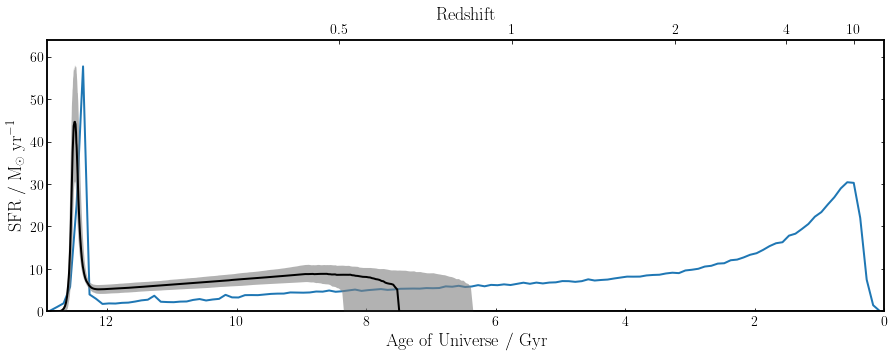

In [229]:
fig, ax = plt.subplots(1,1, figsize=[15,5])
pipes.plotting.add_sfh_posterior(fit, ax)
ax.plot(model_ages, model_sfh)#/(model_m_total/post_m_total))
ylim = ax.get_ylim()
plt.show()

only recovered 0.38837626395043756 of total mass formed.
[0.25 0.5  0.75]
[[ 7.67634054  8.58635766  9.25687153]
 [ 9.25143647  9.93692997 10.38540877]
 [11.30841507 11.60260537 11.79804285]]


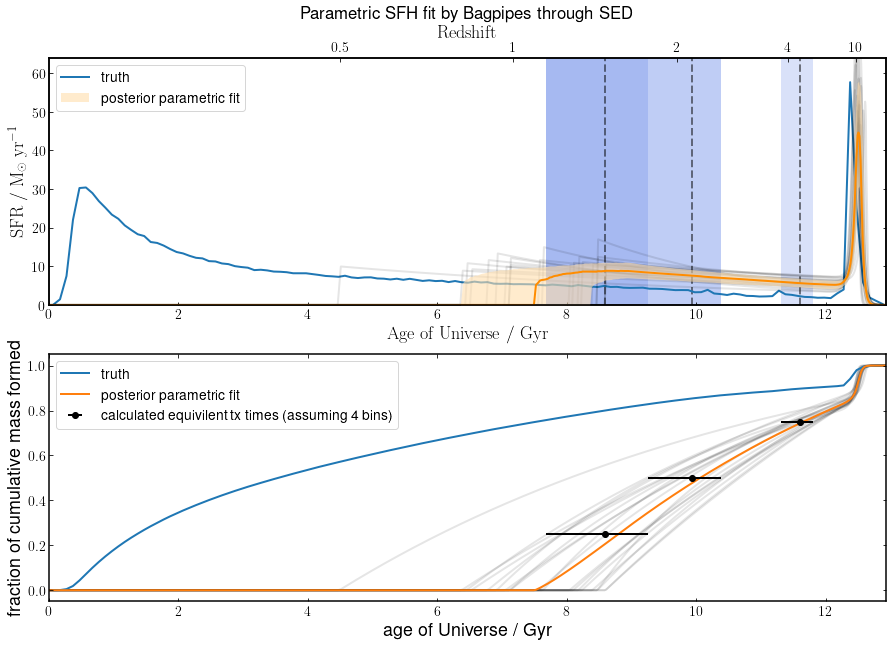

In [230]:
post_ages = age_at_z*10**9 - fit.posterior.sfh.ages[::-1]
median_sfh = np.median(fit.posterior.samples["sfh"], axis=0).T[::-1]
total_median_sfh_mass = np.trapz(median_sfh,x=post_ages)
print('only recovered',total_median_sfh_mass/model_Mstar,'of total mass formed.')
c_median_sfh = integrate_sfh(post_ages, median_sfh, Mstar=total_median_sfh_mass)
#calculating tx and their uncertainties
mass_percentiles = np.linspace(0,1,5)[1:-1]
print(mass_percentiles)
txs = []
for sfh_sample in fit.posterior.samples['sfh']:
    sfh_ = sfh_sample[::-1]
    c_sfh_ = integrate_sfh(post_ages, sfh_)
    txs.append(np.interp(mass_percentiles, c_sfh_, post_ages))
txs = (np.array(txs)/10**9).T
tx_percentiles = []
for i,txi in enumerate(txs):
    tx_percentiles.append(np.percentile(txi, (16,50,84)))
tx_percentiles = np.array(tx_percentiles)
print(tx_percentiles)
#10 random samples
sfh_samps = []
for i in np.random.randint(len(fit.posterior.samples['sfr']), size=20):
    sfh_samp = {}
    sfh_samp['sfh'] = fit.posterior.samples['sfh'][i][::-1]
    sfh_samp['c_sfh'] = integrate_sfh(post_ages, fit.posterior.samples['sfh'][i][::-1])
    sfh_samps.append(sfh_samp)
    
fig, ax = plt.subplots(2, 1, figsize=[15,10])
p0 = ax[0].plot(model_ages, model_sfh, label='truth')
ylims = ax[0].get_ylim()
pipes.plotting.add_sfh_posterior(fit, ax[0], colorscheme='irnbru', label='posterior parametric fit')
for i,[l,m,u] in enumerate(tx_percentiles):
    ax[0].vlines(m, 0, 10*ylims[1], color = 'k', ls='--', alpha=0.5)
    ax[0].fill_betweenx([0,10*ylims[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
for sfh_samp in sfh_samps:
    ax[0].plot(post_ages/10**9, sfh_samp['sfh'], color='k', alpha=0.1)
ax[0].set_xlim(ax[0].get_xlim()[::-1])
ax[0].legend()
ax[0].set_title(f'Parametric SFH fit by Bagpipes through SED')

ax[1].plot(model_ages, c_model_sfh, label='truth', zorder=1)
ax[1].plot(post_ages/10**9, c_median_sfh, label='posterior parametric fit', zorder=1)
ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,4+1)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                          tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='k', label='calculated equivilent tx times (assuming 4 bins)', fmt='o')
#ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', marker='o', label='truth bin boundaries', alpha=0.4)
for sfh_samp in sfh_samps:
    ax[1].plot(post_ages/10**9, sfh_samp['c_sfh'], color='k', alpha=0.1, zorder=-1)
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel(r'fraction of cumulative mass formed')
ax[1].legend()
plt.show()

### How about starlight?

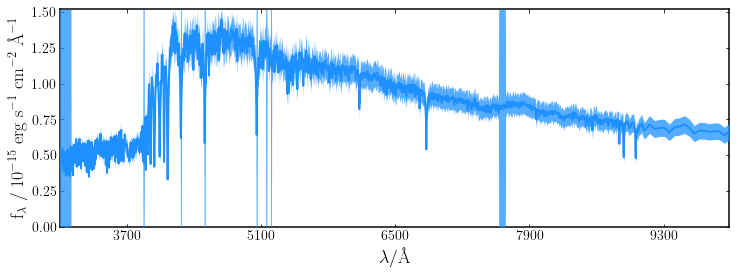


Results loaded from pipes/posterior/yirui_test_snap119_0kpc_veldisp_off_P1/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_0kpc.h5

Fitting not performed as results have already been loaded from pipes/posterior/yirui_test_snap119_0kpc_veldisp_off_P1/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_0kpc.h5. To start over delete this file or change run.



In [186]:
ring_0_ID = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_0kpc'

galaxy = pipes.galaxy(ring_0_ID, load_uds_mask, photometry_exists=False)

fig = galaxy.plot()

runID = "yirui_test_snap119_0kpc_veldisp_off_P1"
fit = pipes.fit(galaxy, {}, run=runID)
fit.fit(verbose=False)

[-6.43435559e+08 -5.65559082e+08 -4.88129610e+08 -4.11144577e+08
 -3.34601433e+08 -2.58497641e+08 -1.82830679e+08 -1.07598040e+08
 -3.27972308e+07  4.15742274e+07] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
only recovered 0.4948435194722449 of total mass formed.
[0.25 0.5  0.75]
[[ 4.15274904  7.35609909  9.05279086]
 [ 7.36097164  9.82046653 10.94504297]
 [12.37592049 12.42481942 12.4606449 ]]


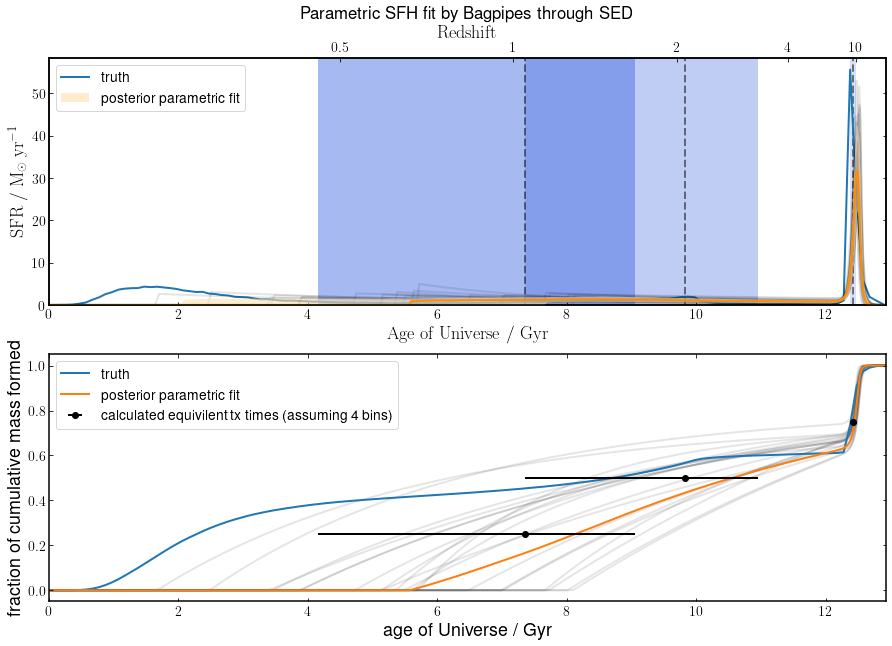

In [205]:
starlight_fit = np.loadtxt(f'Yirui_test_cube/starlight_fit/0.cxt')

#model sfh
ring_model_sfh = sim_data[:,0+3][mask][::-1]
Mstar_total_model_ring = np.trapz(ring_model_sfh, x=model_ages)
c_ring_model_sfh = np.zeros(len(ring_model_sfh))
for i,sfh in enumerate(ring_model_sfh):
    c_ring_model_sfh[i] = np.trapz(ring_model_sfh[:i+1],x=model_ages[:i+1])/Mstar_total_model_ring

post_ages = age_at_z*10**9 - fit.posterior.sfh.ages[::-1]
median_sfh = np.median(fit.posterior.samples["sfh"], axis=0).T[::-1]
print(post_ages[:10], median_sfh[:10])
total_median_sfh_mass = np.trapz(median_sfh,x=post_ages)
print('only recovered',total_median_sfh_mass/Mstar_total_model_ring/10**9,'of total mass formed.')
c_median_sfh = integrate_sfh(post_ages, median_sfh, Mstar=total_median_sfh_mass)
#calculating tx and their uncertainties
mass_percentiles = np.linspace(0,1,5)[1:-1]
print(mass_percentiles)
txs = []
for sfh_sample in fit.posterior.samples['sfh']:
    sfh_ = sfh_sample[::-1]
    c_sfh_ = integrate_sfh(post_ages, sfh_)
    txs.append(np.interp(mass_percentiles, c_sfh_, post_ages))
txs = (np.array(txs)/10**9).T
tx_percentiles = []
for i,txi in enumerate(txs):
    tx_percentiles.append(np.percentile(txi, (16,50,84)))
tx_percentiles = np.array(tx_percentiles)
print(tx_percentiles)
#10 random samples
sfh_samps = []
for i in np.random.randint(len(fit.posterior.samples['sfr']), size=20):
    sfh_samp = {}
    sfh_samp['sfh'] = fit.posterior.samples['sfh'][i][::-1]
    sfh_samp['c_sfh'] = integrate_sfh(post_ages, fit.posterior.samples['sfh'][i][::-1])
    sfh_samps.append(sfh_samp)
    
fig, ax = plt.subplots(2, 1, figsize=[15,10])
p0 = ax[0].plot(model_ages, ring_model_sfh, label='truth')
ylims = ax[0].get_ylim()
pipes.plotting.add_sfh_posterior(fit, ax[0], colorscheme='irnbru', label='posterior parametric fit')
for i,[l,m,u] in enumerate(tx_percentiles):
    ax[0].vlines(m, 0, 10*ylims[1], color = 'k', ls='--', alpha=0.5)
    ax[0].fill_betweenx([0,10*ylims[1]], l, u, facecolor='royalblue', alpha=(1.5-(i+1)/len(txs))/2.5)
for sfh_samp in sfh_samps:
    ax[0].plot(post_ages/10**9, sfh_samp['sfh'], color='k', alpha=0.1)
ax[0].set_xlim(ax[0].get_xlim()[::-1])
ax[0].legend()
ax[0].set_title(f'Parametric SFH fit by Bagpipes through SED')

ax[1].plot(model_ages, c_ring_model_sfh, label='truth', zorder=1)
ax[1].plot(post_ages/10**9, c_median_sfh, label='posterior parametric fit', zorder=1)
ax[1].errorbar(tx_percentiles[:,1], np.linspace(0,1,4+1)[1:-1], xerr=[tx_percentiles[:,1]-tx_percentiles[:,0],
                                                                          tx_percentiles[:,2]-tx_percentiles[:,1]],
              color='k', label='calculated equivilent tx times (assuming 4 bins)', fmt='o')
#ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', marker='o', label='truth bin boundaries', alpha=0.4)
for sfh_samp in sfh_samps:
    ax[1].plot(post_ages/10**9, sfh_samp['c_sfh'], color='k', alpha=0.1, zorder=-1)
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel(r'fraction of cumulative mass formed')
ax[1].legend()
plt.show()

[4.24069744e+08 9.24069744e+08 1.42406974e+09 1.92406974e+09
 2.42406974e+09 2.92406974e+09 3.42406974e+09 3.92406974e+09
 4.42406974e+09 4.92406974e+09] [ 0.          4.07723162  9.80769689  0.          0.11771377  0.
  0.         10.62993032  0.          0.        ]
21021057080.960182
only recovered 0.9032818196801611 of total mass formed.
[0.25 0.5  0.75]
[ 1.23876194  3.72968999 12.46290976]


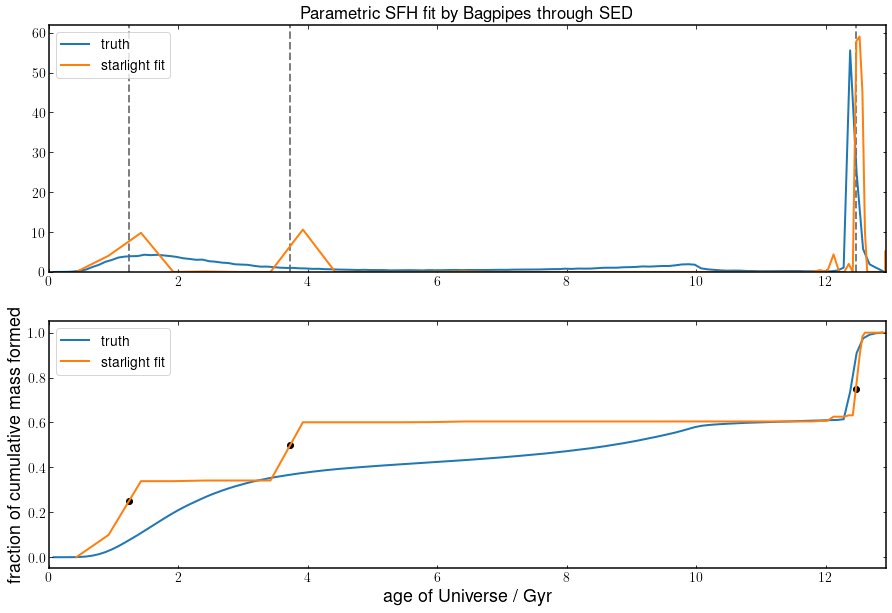

In [220]:
starlight_ages_ = age_at_z - starlight_fit[:,0][::-1]
age_gaps = np.diff([*starlight_ages_,age_at_z])
starlight_sfh = (starlight_fit[:,1][::-1]/100*Mstar_total_model_ring)/age_gaps
starlight_ages = starlight_ages_[starlight_ages_>0]
starlight_sfh = starlight_sfh[starlight_ages_>0]

post_ages = starlight_ages*10**9
median_sfh = starlight_sfh
print(post_ages[:10],median_sfh[:10])
total_median_sfh_mass = np.trapz(median_sfh,x=post_ages)
print(total_median_sfh_mass)
print('only recovered',total_median_sfh_mass/Mstar_total_model_ring/10**9,'of total mass formed.')
c_median_sfh = np.cumsum(starlight_fit[:,1][::-1]/100)[starlight_ages_>0]
c_median_sfh = (c_median_sfh-c_median_sfh[0])/(c_median_sfh[-1]-c_median_sfh[0])
#calculating tx and their uncertainties
mass_percentiles = np.linspace(0,1,5)[1:-1]
print(mass_percentiles)
txs = np.interp(mass_percentiles, c_median_sfh, post_ages)/10**9
print(txs)
    
fig, ax = plt.subplots(2, 1, figsize=[15,10])
p0 = ax[0].plot(model_ages, ring_model_sfh, label='truth')
ax[0].plot(post_ages/10**9, median_sfh, label='starlight fit')
ylims = ax[0].get_ylim()
ax[0].vlines(txs, 0, 10*ylims[1], color = 'k', ls='--', alpha=0.5)
ax[0].set_xlim([0,age_at_z])
ax[0].set_ylim([0,ylims[1]])
ax[0].legend()
ax[0].set_title(f'Parametric SFH fit by Bagpipes through SED')

ax[1].plot(model_ages, c_ring_model_sfh, label='truth', zorder=1)
ax[1].plot(post_ages/10**9, c_median_sfh, label='starlight fit', zorder=1)
ax[1].scatter(txs, mass_percentiles, color='k')
#ax[1].scatter(tx*age_at_z, np.linspace(0,1,Nbins+1)[1:-1], color='k', marker='o', label='truth bin boundaries', alpha=0.4)
ax[1].set_xlim([0,age_at_z])
ax[1].set_xlabel('age of Universe / Gyr')
ax[1].set_ylabel(r'fraction of cumulative mass formed')
ax[1].legend()
plt.show()

In [193]:
starlight_fit

array([[1.00000000e-03, 0.00000000e+00],
       [2.00000000e-03, 2.27830000e-02],
       [3.00000000e-03, 0.00000000e+00],
       [9.00000000e-03, 0.00000000e+00],
       [2.20000000e-02, 0.00000000e+00],
       [5.70000000e-02, 0.00000000e+00],
       [8.10000000e-02, 0.00000000e+00],
       [9.00000000e-02, 0.00000000e+00],
       [1.02000000e-01, 0.00000000e+00],
       [1.43000000e-01, 0.00000000e+00],
       [1.61000000e-01, 0.00000000e+00],
       [1.81000000e-01, 0.00000000e+00],
       [2.03000000e-01, 1.46030000e-03],
       [2.27000000e-01, 0.00000000e+00],
       [2.55000000e-01, 0.00000000e+00],
       [2.86000000e-01, 0.00000000e+00],
       [3.21000000e-01, 1.51659200e+00],
       [3.60000000e-01, 7.54490000e+00],
       [4.04000000e-01, 1.11594780e+01],
       [4.53000000e-01, 1.21963200e+01],
       [5.09000000e-01, 0.00000000e+00],
       [5.71000000e-01, 5.37910000e-01],
       [6.41000000e-01, 0.00000000e+00],
       [7.19000000e-01, 0.00000000e+00],
       [8.060000

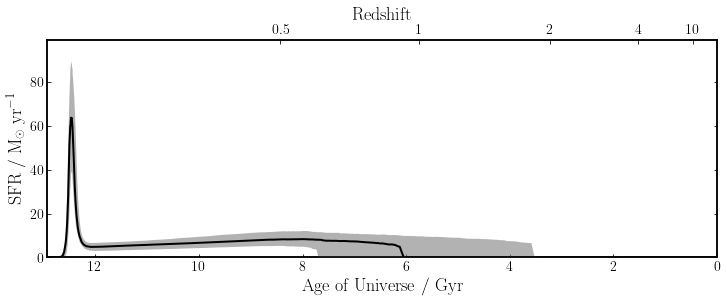

In [171]:
fig = fit.plot_sfh_posterior(save=False, show=True)